In [1]:
from __future__ import absolute_import, division, print_function

import pathlib

from astropy.io import fits
import matplotlib as m
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Conv1D
import tensorflow.keras.backend as K
print(tf.__version__)

from scipy.io import readsav
from scipy.signal import deconvolve
from scipy.ndimage.interpolation import shift

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from intdim_mle import intrinsic_dim_sample_wise, intrinsic_dim_scale_interval
from intdim_mle import repeated

2.1.0


In [2]:
font = 'Helvetica'
params = {'backend': 'tkagg',
          'axes.labelsize': 15,
          'axes.titlesize': 15,
          'font.size': 12,
          'legend.fontsize': 12,
          'font.family': 'sans-serif',
          'font.sans-serif': font,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'text.usetex': True,
          'figure.dpi': 125,
          'lines.linewidth': 1.0,
          'axes.linewidth':1.0,
          'image.interpolation'  : 'nearest',
          'xtick.major.size'     : 5,      # major tick size in points
          'xtick.minor.size'     : 3.5,      # minor tick size in points
          'xtick.major.width'    : 0.5,    # major tick width in points
          'xtick.minor.width'    : 0.3,    # minor tick width in points
          'axes.spines.top': False,
          'axes.spines.right':False,
          'xtick.top': False,
          'ytick.right': False,
          'axes.formatter.useoffset': False
}
m.rcParams.update(params)
m.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]

m.rcParams['mathtext.fontset'] = 'custom'
m.rcParams['mathtext.rm'] = font
m.rcParams['mathtext.it'] = font+':italic'
m.rcParams['mathtext.bf'] = font+':bold'
m.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
fSizeAxisLabel = 10

In [3]:
def convolve(signal, filterProfile): 

    return np.convolve(signal, filterProfile)

def customLoss(yTrue, yPred):

    weights1 = K.constant(weights)
    return K.mean(K.square(yTrue - yPred) * weights1)

def customLoss1(yTrue, yPred):

    weights11 = K.constant(weights[0:40])
    return K.mean(K.square(yTrue - yPred) * weights11)

In [4]:
def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    print(hdul.header)
    return spectrum 

def build_simple_model1():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  waveNumd  = 100
  model = keras.Sequential([
    layers.Conv1D(50, (3,),
        activation='relu',strides=1,input_shape=[waveNumd,1]),
    layers.Conv1D(40, (3,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(25, (3,),
        activation='relu'),
    layers.Conv1D(15, (4,),
        activation='relu'),
    layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(40,activation=tf.nn.relu),
    layers.Dense(40,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)


  model.compile(loss=customLoss,
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_conv_model():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  waveNumd  = dl
  model = keras.Sequential([
    layers.Conv1D(15, (3,),
        activation='relu', strides=1, input_shape=[waveNumd, 1]),
    layers.Conv1D(30, (5,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(15, (3,),
        activation='relu'),
    layers.Conv1D(25, (3,),
        activation='relu'),
    #layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    #layers.Dense(30,activation=tf.nn.relu),
    layers.Dense(30,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_conv_model2():
    #build the NN needed for the problem accomodating a single
    #convolutional layer and two densely connected hidden layer
    kSzConv1D = 3
    waveNumd  = dl
    y1 = layers.Input(shape=[dl,1])
    y = layers.Conv1D(5, (kSzConv1D, ), activation='relu')(y1)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(10, (kSzConv1D, ), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(20, (kSzConv1D, ), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    #y = layers.Dense(100,activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(20, (kSzConv1D, ), activation='relu')(y)
    #y = layers.Dropout(0.2)(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(10, (kSzConv1D, ), activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(5, (kSzConv1D, ), activation='relu')(y)
    #layers.GlobalAveragePooling1D(),
    #y = layers.Flatten()(y)
    #y = layers.Dropout(0.5)(y)
    y = layers.Flatten()(y)
    y = layers.Dense(waveNumd, activation=tf.nn.relu)(y)
    y2 = layers.Add()([y, y1[:,  :, 0]])
    y = layers.Dense(dl, activation=tf.nn.relu)(y2)

    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    
    x = layers.Dense(dl, activation='linear')(y2)
    optimizer = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=1.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss='mean_squared_error', optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

def build_conv_model_MP(waveNumd, ratio):
    '''
    build the NN needed for the problem accomodating a single
    convolutional layer and two densely connected hidden layer
    '''
    kSzConv1D = 3
    # waveNumd  = 40
    
    y1 = layers.Input(shape=[int(waveNumd/ratio),1])
    y = layers.Conv1D(5,  (kSzConv1D, ), activation='relu')(y1)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(10, (kSzConv1D, ), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(20, (kSzConv1D,), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    # y = layers.Conv1D(20, (kSzConv1D, ), activation='relu')(y)
    # y = layers.Dense(waveNumd,activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(20,(kSzConv1D,), activation='relu')(y)
    # y = layers.Dropout(0.2)(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(10,(kSzConv1D,), activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(5,(kSzConv1D,), activation='relu')(y)
    #layers.GlobalAveragePooling1D(),
    #y = layers.Flatten()(y)
    #y = layers.Dropout(0.5)(y)
    y = layers.Flatten()(y)
    #y2 = layers.Dense(waveNumd,activation=tf.nn.relu)(y)
    #y2 = layers.Add()([y,y1[:,:,0]])
    #y = layers.Dense(40,activation=tf.nn.relu)(y2)

      #layers.GlobalAveragePooling1D(),
      #layers.Dense(20, activation='sigmoid'),    
    y = layers.Dense(10, activation='sigmoid')(y)
    x = layers.Dense(waveNumd,activation='linear')(y)
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model2 = keras.models.Model(inputs=y1, outputs=x)
    model2.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    return model2

def build_dense_model():
    waveNumd  = 100
    numDense1 = 256
    y1 = layers.Input(shape=[waveNumd,1])
    y = layers.Flatten()(y1)
    y = layers.Dense(numDense1,activation='relu')(y)
    #y = layers.Dense(numDense1,activation='relu')(y)
    y = layers.Dense(numDense1,activation='relu')(y)
    y = layers.Dropout(0.2)(y)
    y = layers.Dense(numDense1,activation='relu')(y)
    y = layers.Dense(numDense1,activation='relu')(y)
    #y = layers.Dense(256,activation='relu')(y)
    #y = layers.Flatten()(y)
    y = layers.Dense(waveNumd,activation='sigmoid')(y)
    y = layers.Add()([y,y1[:,:,0]])
    x = layers.Dense(waveNumd,activation='linear')(y)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss=customLoss,
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model 


def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    return spectrum 

def radial_dist(sizeX,sizeY):
    '''Prepare a flat array of the radial distance of the pixel
    from the optical center of the system -- used for removing 
    uncorrected blueshifts
    '''
    
    centerX = sizeX/2
    centerY = sizeY/2
    
    radialDistances = np.zeros((sizeX,sizeY))
    
    for ii in range(sizeX):
        for jj in range(sizeY):
            radialDistances[ii,jj] = (centerX-ii)**2 + (centerY-jj)**2
    
    radialDistances = np.reshape(radialDistances,(sizeX*sizeY))
    
    return radialDistances


def prepare_data(spectrum):
    shape = spectrum.shape
    spec = np.reshape(spectrum,(shape[0],shape[1]*shape[2]))
    spec = np.swapaxes(spec,0,1)
    return spec

    
def plot_spec_profile_comparison(wavescale,profile_FP1,profile_FP2,profile_inferred):
    plt.figure(dpi=250,figsize=(8,6))
    #plt.style.use('ggplot')
    plt.plot(wavescale,profile_FP1,'g.--',label='Convolved spectrum')
    plt.plot(wavescale,profile_FP2,'b.--',label='Original spectrum')
    plt.plot(wavescale,profile_inferred,'k.--',label = 'Inferred spectrum')
    plt.legend()
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Wavelength, $\AA$')
    plt.grid(alpha=0.5)
    plt.savefig('Figures/Comparison_FISS.png',transparent=True)
    plt.show()


def Lorentzian(x0,x,gamma):
    x2  = (x0-x)*(x0-x)
    exp = gamma/(np.pi*(x2+gamma*gamma))
    return exp


def Gaussian(x,mu,sigma):
    return np.exp((-1)*(x-mu)*(x-mu)/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma)


def produce_FP_transmission_peak(dlambda,lambda_0,Nlambda,FPnum,wavelength):
    wave_I = np.linspace((lambda_0-dlambda*Nlambda/2),(lambda_0+dlambda*Nlambda/2),num=Nlambda)
    ab = readsav('IBIS.FP1.FP2.profiles.6563.8542.sav')
    wave          = np.linspace(-24,24,num=48001)
    if wavelength == 6563:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_6563']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_6563'] 
    if wavelength == 8542:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_8542']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_8542']
    filterProfile = np.interp(wave_I,wave,t)
    return filterProfile

## Preview of some of the FISS data.

Shape of haData is 100 256 512


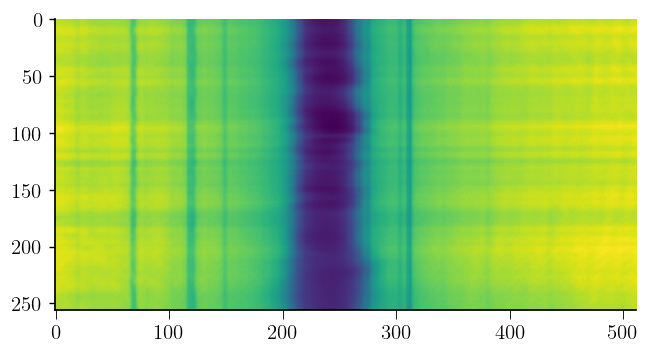

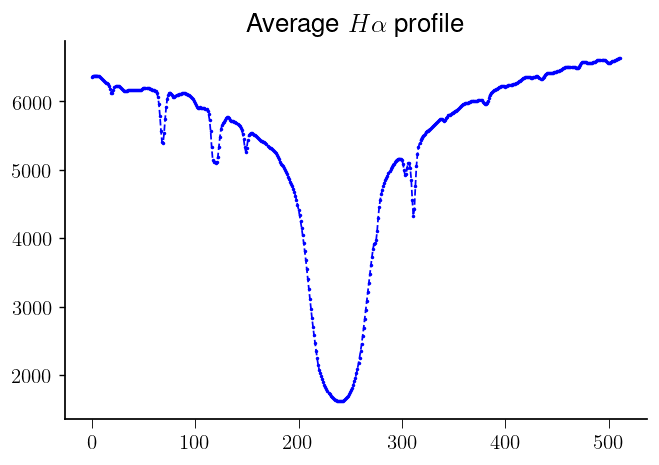

Shape of caData is 100 250 502


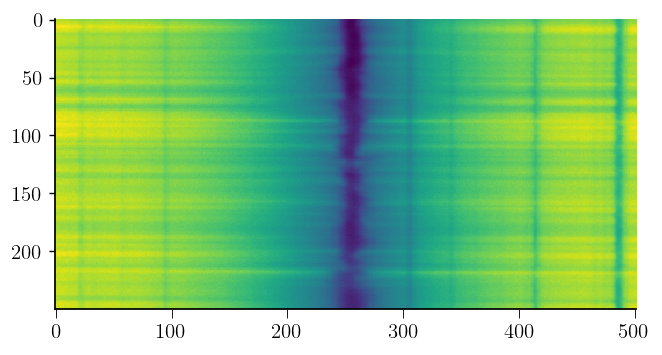

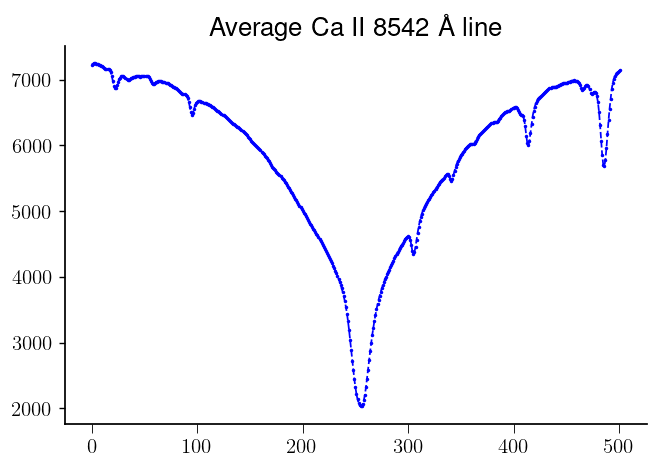

In [5]:
haData = load_spectral_profiles('','FISS_20160622_174421_A1.fts')
haSpectralRes = 0.0190416632507
print('Shape of haData is %d %d %d'%haData.shape)
plt.imshow(haData[0,:,:])
plt.show()

plt.title('Average $H\\alpha$ profile')
plt.plot(np.mean(haData[:,:,:],axis=(0,1)), 'b.--', markersize=2)
plt.show()

caData = load_spectral_profiles('','FISS_20160622_175412_B1.fts')
caSpectralRes = 0.0256741359106
print('Shape of caData is %d %d %d'%caData.shape)
plt.imshow(caData[0,:,:])
plt.show()

plt.title('Average Ca II 8542 \AA~line')
plt.plot(np.mean(caData[:,:,:],axis=(0,1)), 'b.--', markersize=2)
plt.show()

## Convolve the FISS data with some PSFs

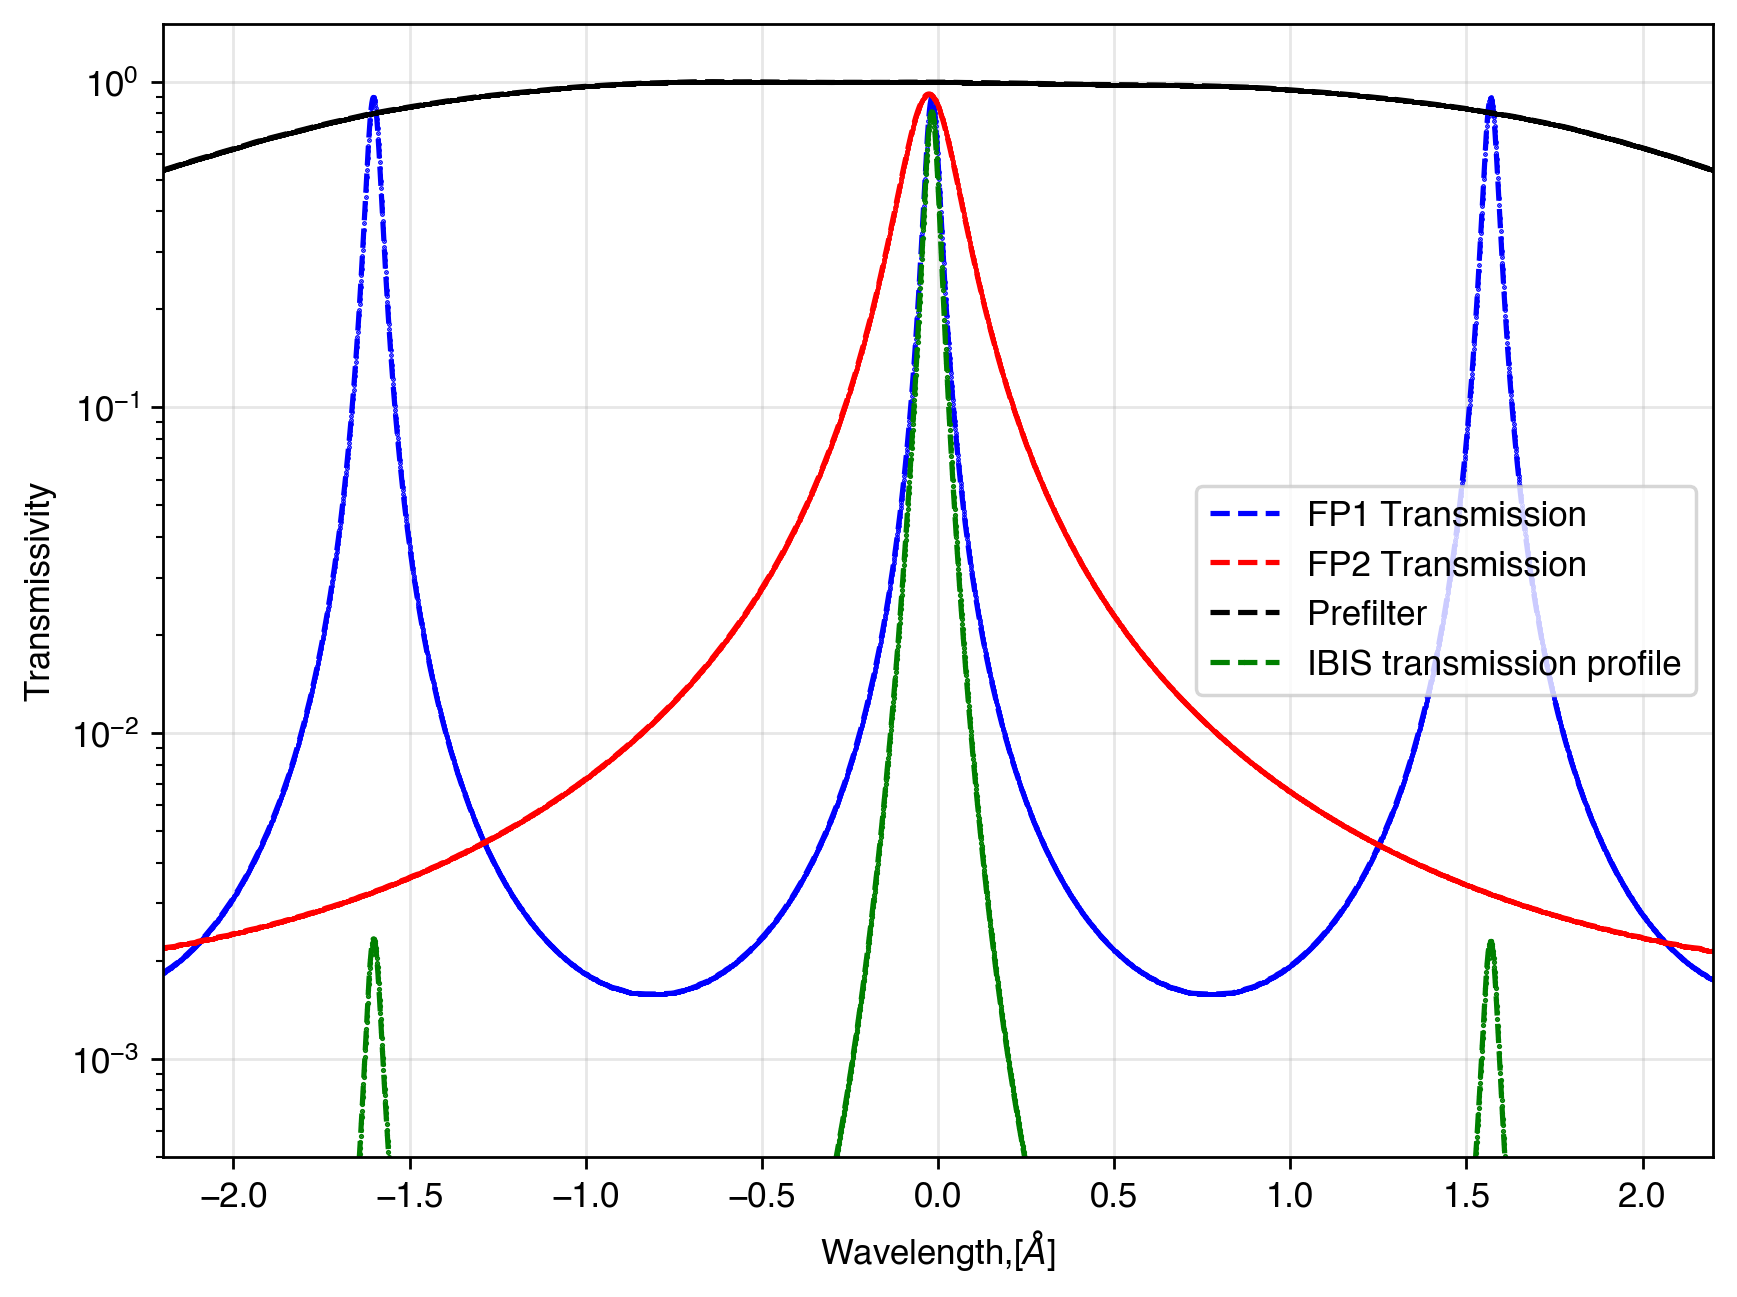

In [5]:
wave = np.linspace(-24, 24, num=48001)
ab = readsav('IBIS.FP1.FP2.profiles.6563.8542.sav')
pf_ha = readsav('H-alpha_IBIS_Prefilter.sav')
pf   = readsav('prefilter.8542.reference.profile.Apr2015.sav')
pf_f = np.interp(wave, pf['PREFILT8542_REF_WVSCL'], pf['PREFILT8542_REF_MAIN'], left=0, right=0)
m.rcParams.update({'font.sans-serif':'Helvetica'})
csfont = {'fontname':'Helvetica'}
markersize1 = .75
plt.figure(figsize=(8, 6), dpi=250)

plt.plot(wave, ab['ibis_fp1_profile_8542'], 'b.--', label='FP1 Transmission', markersize=markersize1)
plt.plot(wave, ab['ibis_fp2_profile_8542'], 'r.--', label='FP2 Transmission', markersize=markersize1)
plt.plot(wave, pf_f,'k.--',label='Prefilter', markersize=markersize1)
plt.plot(wave, ab['ibis_fp1_profile_8542']*ab['ibis_fp2_profile_8542']*pf_f, 'g.--',
         markersize=1, label='IBIS transmission profile')
plt.legend()
plt.yscale('log')
plt.ylabel('Transmissivity', **csfont)
plt.ylim(5e-4, 1.5)
plt.xlabel('Wavelength,[$\\AA$]', **csfont)
plt.xlim(-2.2, 2.2)
plt.grid(alpha=0.3)
plt.savefig('Figures/FP_transmission_profile.png', transparent=True)
plt.show()

np.savez("Fig_3_1.npz", wave=wave, fp1 = ab['ibis_fp1_profile_8542'],
         fp2=ab['ibis_fp2_profile_8542'], pf_f=pf_f)
np.load("Fig_3_1.npz")

### Convolve the whole FISS FOV

NameError: name 'a' is not defined

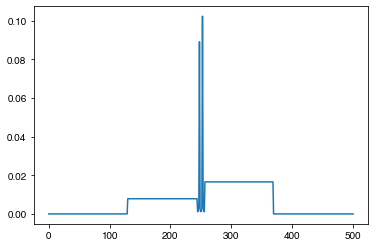

<Figure size 1200x800 with 0 Axes>

In [6]:
Nlambda      = 502
dlambda      = 0.024
trans_filter = produce_FP_transmission_peak(4,0,Nlambda,2,6563)
wave         = np.linspace(-.5*Nlambda*dlambda,.5*Nlambda*dlambda,num=Nlambda)

trans_filter[0:130] = 0
trans_filter[370:] = 0

trans_filter_total = np.sum(trans_filter)

plt.plot(trans_filter)
#plt.grid()
#plt.yscale('log')
#plt.show()
plt.figure(dpi=200)
b = np.convolve(a[0,0,:],trans_filter/trans_filter_total,mode='same')
print("Shape of b is %d"%b.shape)
print("Shape of a[0,0,:] is %d"%a[0,0,:].shape)
plt.plot(wave,(a[0,0,:]),'r.--',label='Genuine')
plt.plot(wave,(b[0:Nlambda]),'g.--',label='Convolved')
plt.legend()
plt.grid()
plt.show()

### Convolve the Ha and Ca data with the wide FP Transmission profile

502
(100, 250, 502)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


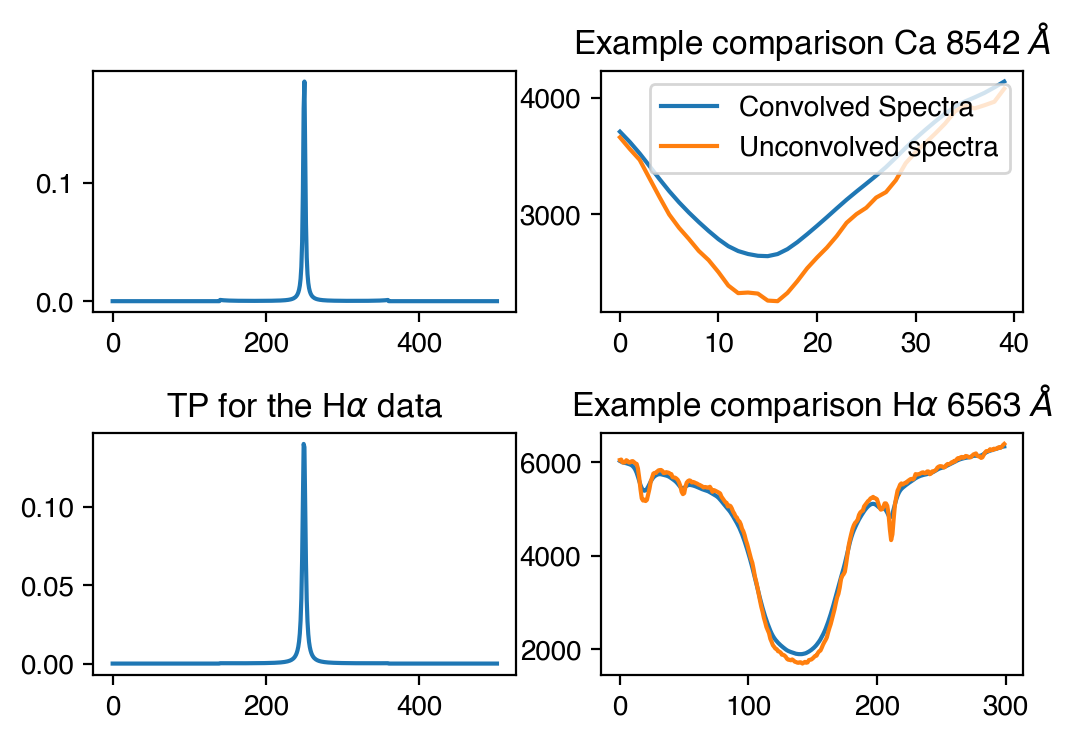

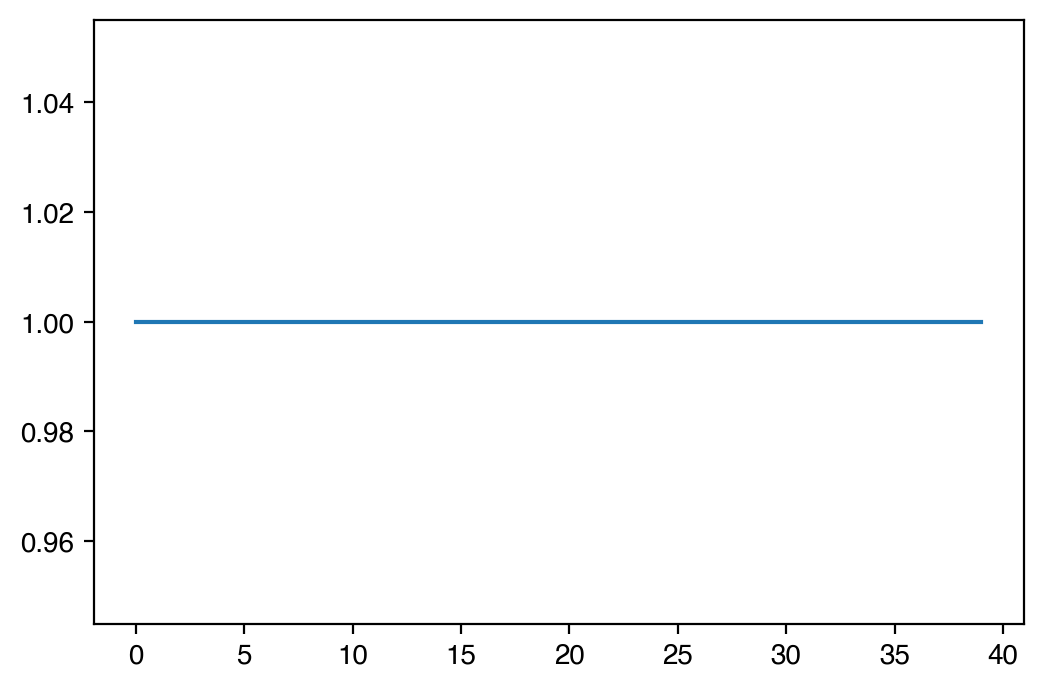

In [7]:
Nlambda_ca = caData.shape[2]
Nx_ca      = caData.shape[0]
Ny_ca      = caData.shape[1]

print(Nlambda_ca)
print(caData.shape)

lStart = 240
lEnd   = 280
dl     = lEnd - lStart

fig, ax = plt.subplots(nrows=2, ncols=2, dpi=200)
fig.subplots_adjust(hspace=.5)

TProfile = produce_FP_transmission_peak(caSpectralRes, 0, Nlambda_ca, 2, 6563)

TProfile[0:140] = 0
TProfile[360:] = 0
TProfile = TProfile / np.sum(TProfile)
ax[0, 0].plot(TProfile)

caConvolved = np.zeros((Nx_ca, Ny_ca, Nlambda_ca))

for ii in range(Nx_ca):
    for jj in range(Ny_ca):
        caConvolved[ii, jj, :] = np.convolve(caData[ii, jj, :], TProfile, mode='same')

ax[0,1].set_title('Example comparison Ca 8542 $\AA$')
ax[0,1].plot(caConvolved[80, 20, lStart:lEnd], label='Convolved Spectra')
ax[0,1].plot(caData[80, 20, lStart:lEnd], label='Unconvolved spectra')
ax[0,1].legend()

Nlambda_ha = haData.shape[2]
Nx_ha      = haData.shape[0]
Ny_ha      = haData.shape[1]


TProfile = produce_FP_transmission_peak(haSpectralRes,0,Nlambda,2,6563)

TProfile[0:140] = 0
TProfile[360:] = 0
TProfile = TProfile / np.sum(TProfile)


ax[1,0].plot(TProfile)
ax[1,0].set_title('TP for the H$\\alpha$ data')

haConvolved = np.zeros((Nx_ha,Ny_ha,Nlambda_ha))

for ii in range(Nx_ha):
    for jj in range(Ny_ha):
        haConvolved[ii,jj,:] = np.convolve(haData[ii,jj,:],TProfile,mode='same')

lStart_Ha = 100
lEnd_Ha   = 400
dl_Ha     = lEnd - lStart
ax[1, 1].set_title('Example comparison H$\\alpha$ 6563 $\AA$')
ax[1, 1].plot(haConvolved[80, 20, lStart_Ha:lEnd_Ha], label='Convolved spectra')
ax[1, 1].plot(haData[80, 20, lStart_Ha:lEnd_Ha], label='Unconvolved spectra')

fig.show()

fig1 = plt.figure(dpi=200)

mean_profile_8542 = (np.mean(np.mean(caData,axis=0),axis=0))[lStart:lEnd]

power_weigths     = 0
norm_const        = mean_profile_8542[0]**power_weigths
weights           = norm_const/mean_profile_8542**power_weigths

plt.plot(weights)
plt.show()

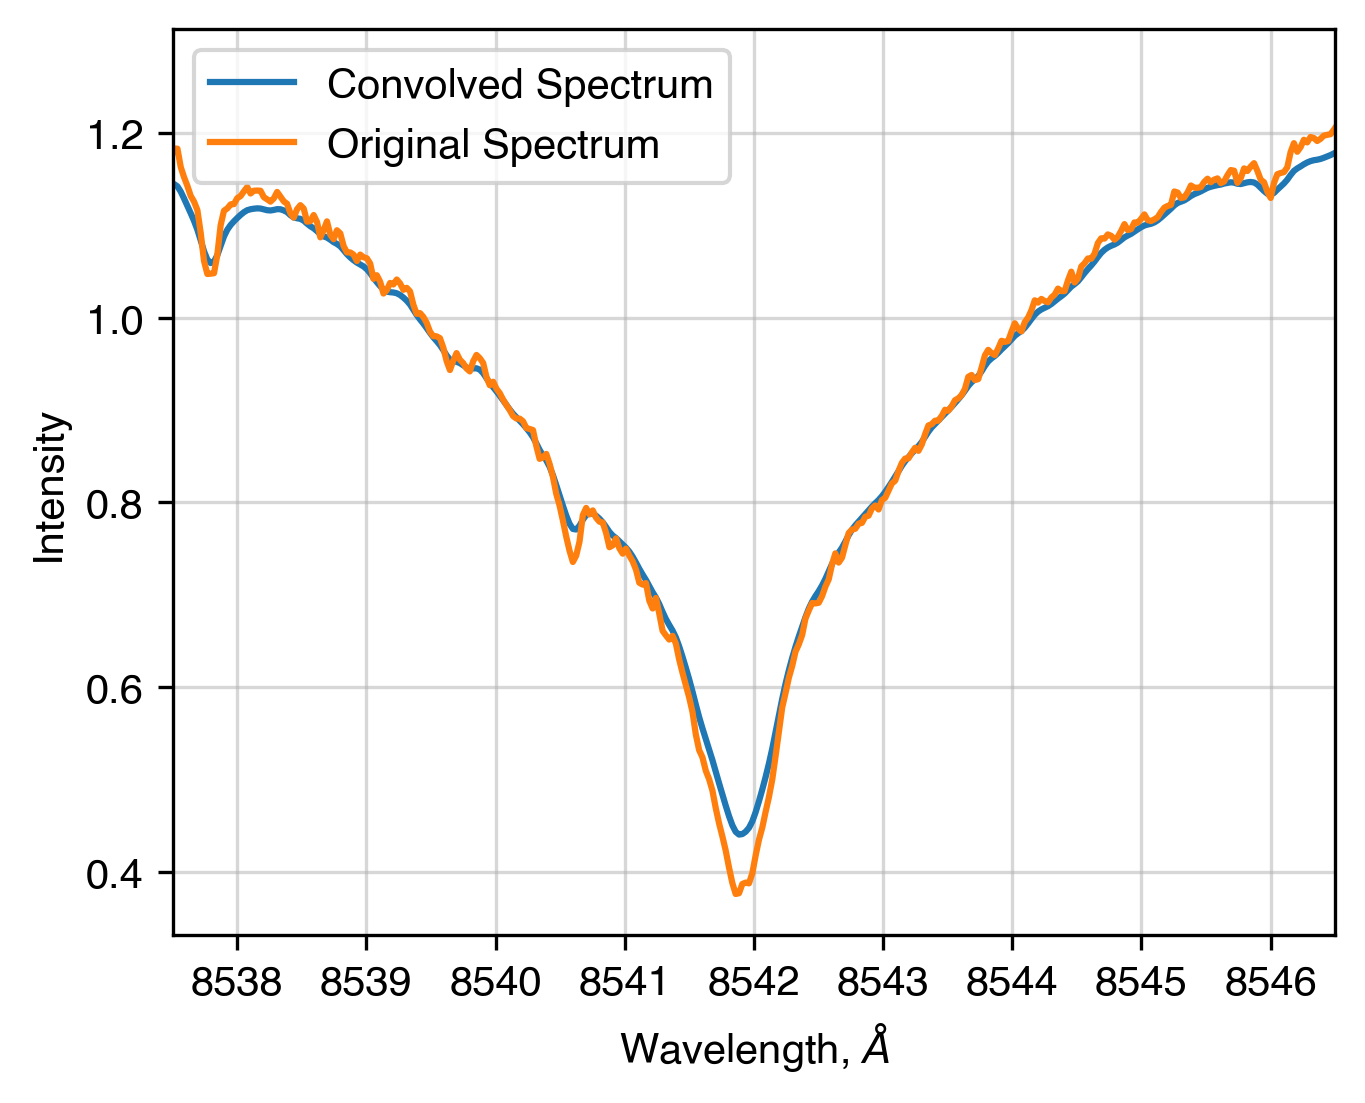

In [9]:
plt.figure(dpi=300,figsize=(5,4))
#plt.title('Example comparison Ca 8542 $\AA$')

norm   = 6000
m.rcParams.update({'font.sans-serif':'Helvetica'})
csfont = {'fontname':'Helvetica'}
wave   = np.linspace(caSpectralRes*502/2,caSpectralRes*502/(-2),num=502)+8542
plt.plot(wave,caConvolved[80,20,:]/norm,label='Convolved Spectrum')
plt.plot(wave,caData[80,20,:]/norm,label='Original Spectrum')
plt.xlabel('Wavelength, $\\AA$',**csfont)
plt.ylabel('Intensity',**csfont)
plt.xlim(8537.5,8546.5)
plt.grid(alpha=0.5)
plt.legend()
plt.savefig('Figures/CA_FISS_Example_conv11.png',transparent=True)
plt.show()

# Build and train the model

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 45, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 43, 5)        20          input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_12 (MaxPooling1D) (None, 21, 5)        0           conv1d_24[0][0]                  
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 19, 10)       160         max_pooling1d_12[0][0]           
____________________________________________________________________________________________

The normalization values for original are 5004.53232 and convolved images 5000.971318278386


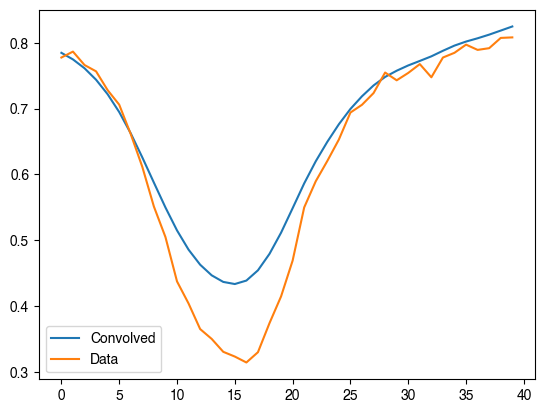

In [61]:
norm_data = np.mean(caData[:,:,200],axis=(0,1))
norm_conv = np.mean(caConvolved[:,:,200],axis=(0,1))
print(f'The normalization values for original are {norm_data} and convolved images {norm_conv}')

caData_Conv_norm = (caConvolved / norm_conv)[:,:,lStart:lEnd] 
caData_norm      = (caData / norm_conv)[:,:,lStart:lEnd] 
   
plt.plot(caData_Conv_norm[90,90,:], label='Convolved')
plt.plot(caData_norm[90,90,:], label='Data')
plt.legend()
plt.show()

In [45]:
model1 = build_conv_model2()
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45, 1)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 43, 5)        20          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 21, 5)        0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 19, 10)       160         max_pooling1d[0][0]              
______________________________________________________________________________________________

In [157]:
EPOCHS = 10000
optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    model1.optimizer = tf.keras.optimizers.Adam(lr=1e-1, beta_1=0.9,
              beta_2=0.999, epsilon=1e-8, decay=1.0, amsgrad=False)

if optimizer == 'SGD': 
    model1.optimizer = tf.keras.optimizers.SGD(lr=1, nesterov=True)

history = model1.fit(np.reshape(caData_Conv_norm, (int(Nx_ca * Ny_ca), dl, 1)),
                     np.reshape(caData_norm, (int(Nx_ca * Ny_ca), dl)),
                     epochs=EPOCHS, validation_split=0.20, verbose=2)

'''
history = model.fit(np.reshape(caData_Conv_norm[:,:,lStart:lEnd],(int(Nx_ca*Ny_ca),dl,1)),
                    np.reshape(caData_norm[:,:,lStart:lEnd],(int(Nx_ca*Ny_ca),dl)),
                    epochs=EPOCHS,validation_split=0.25 , verbose=2)
'''

ValueError: Error when checking input: expected input_1 to have shape (45, 1) but got array with shape (40, 1)

235 280
(100, 250, 45)


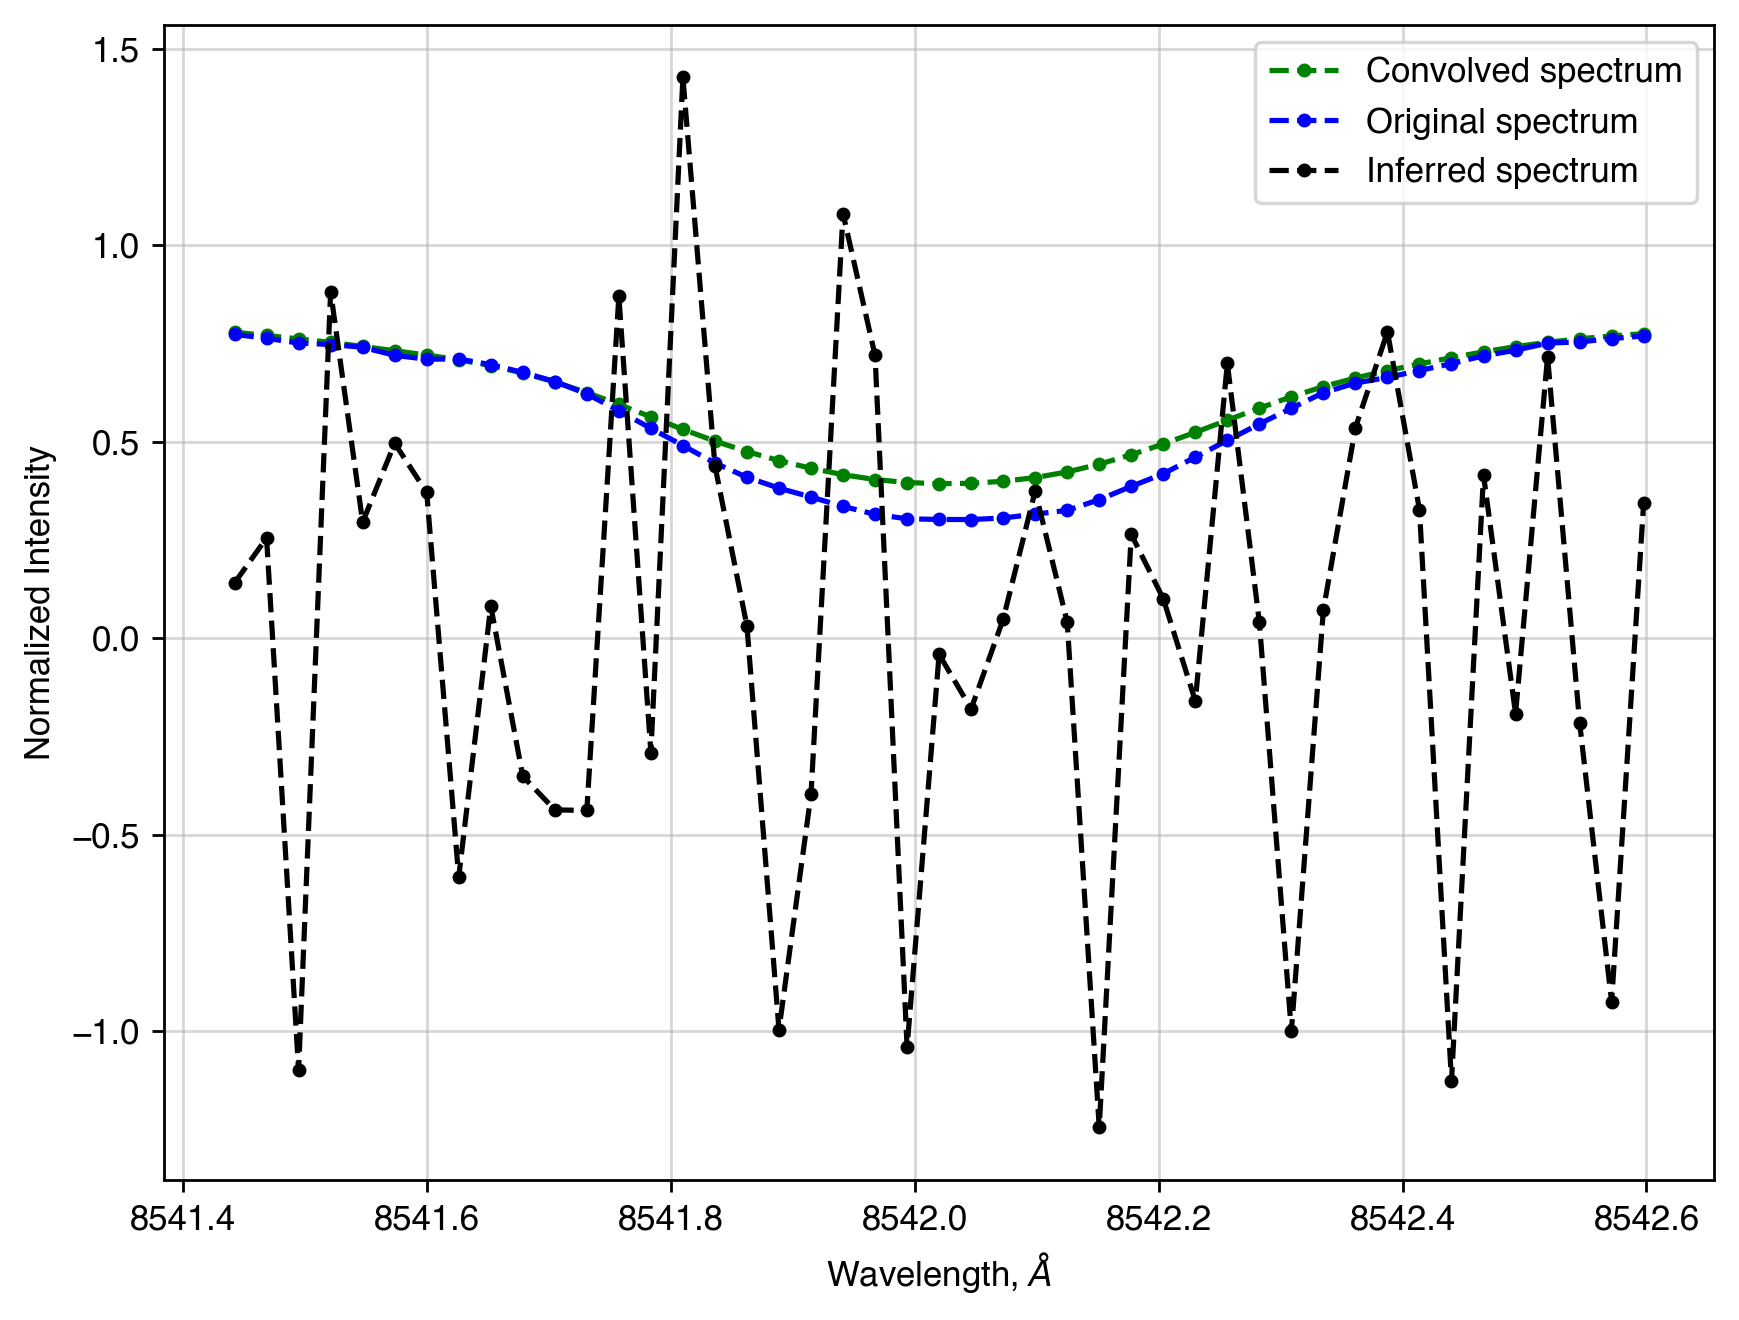

In [46]:
prevNum  = 4
prevNumy = 21
delta    = 2
print(lStart,lEnd)
#im       = model.predict(train_set[:,:,:])
#plt.figure(dpi=200)
#plt.imshow(np.reshape(train_set[:,30,0],(968,968)))
#plt.show()
#plt.figure(dpi=200)Z
#plt.imshow(np.reshape(im[:,30],(968,968)))
#plt.show()
#plt.figure(dpi=200)
#plt.imshow(np.reshape(truth_set[:,30],(968,968)))
#plt.show()

print(caData_Conv_norm.shape)

res = model1.predict(np.reshape(caData_Conv_norm[prevNum, prevNumy, :],(1, 45, 1)))

wavescale = np.linspace(-1* dl * caSpectralRes/2 + 8542.02, dl * caSpectralRes/2 + 8542.02, num=dl)
plot_spec_profile_comparison(wavescale, caData_Conv_norm[prevNum, prevNumy, :],
                             caData_norm[prevNum, prevNumy, :], res[0, :])
np.savez('Fig2_2_data.npz', dl, caSpectralRes, caData_norm, caData_Conv_norm, prevNum, prevNumy,
         res, wavescale)

5000.971318278386
25000/25000 [==============================] - 1s 36us/sample
The elapsed time for 1M Pixel inversion is:   0.99 seconds
(25000, 45)


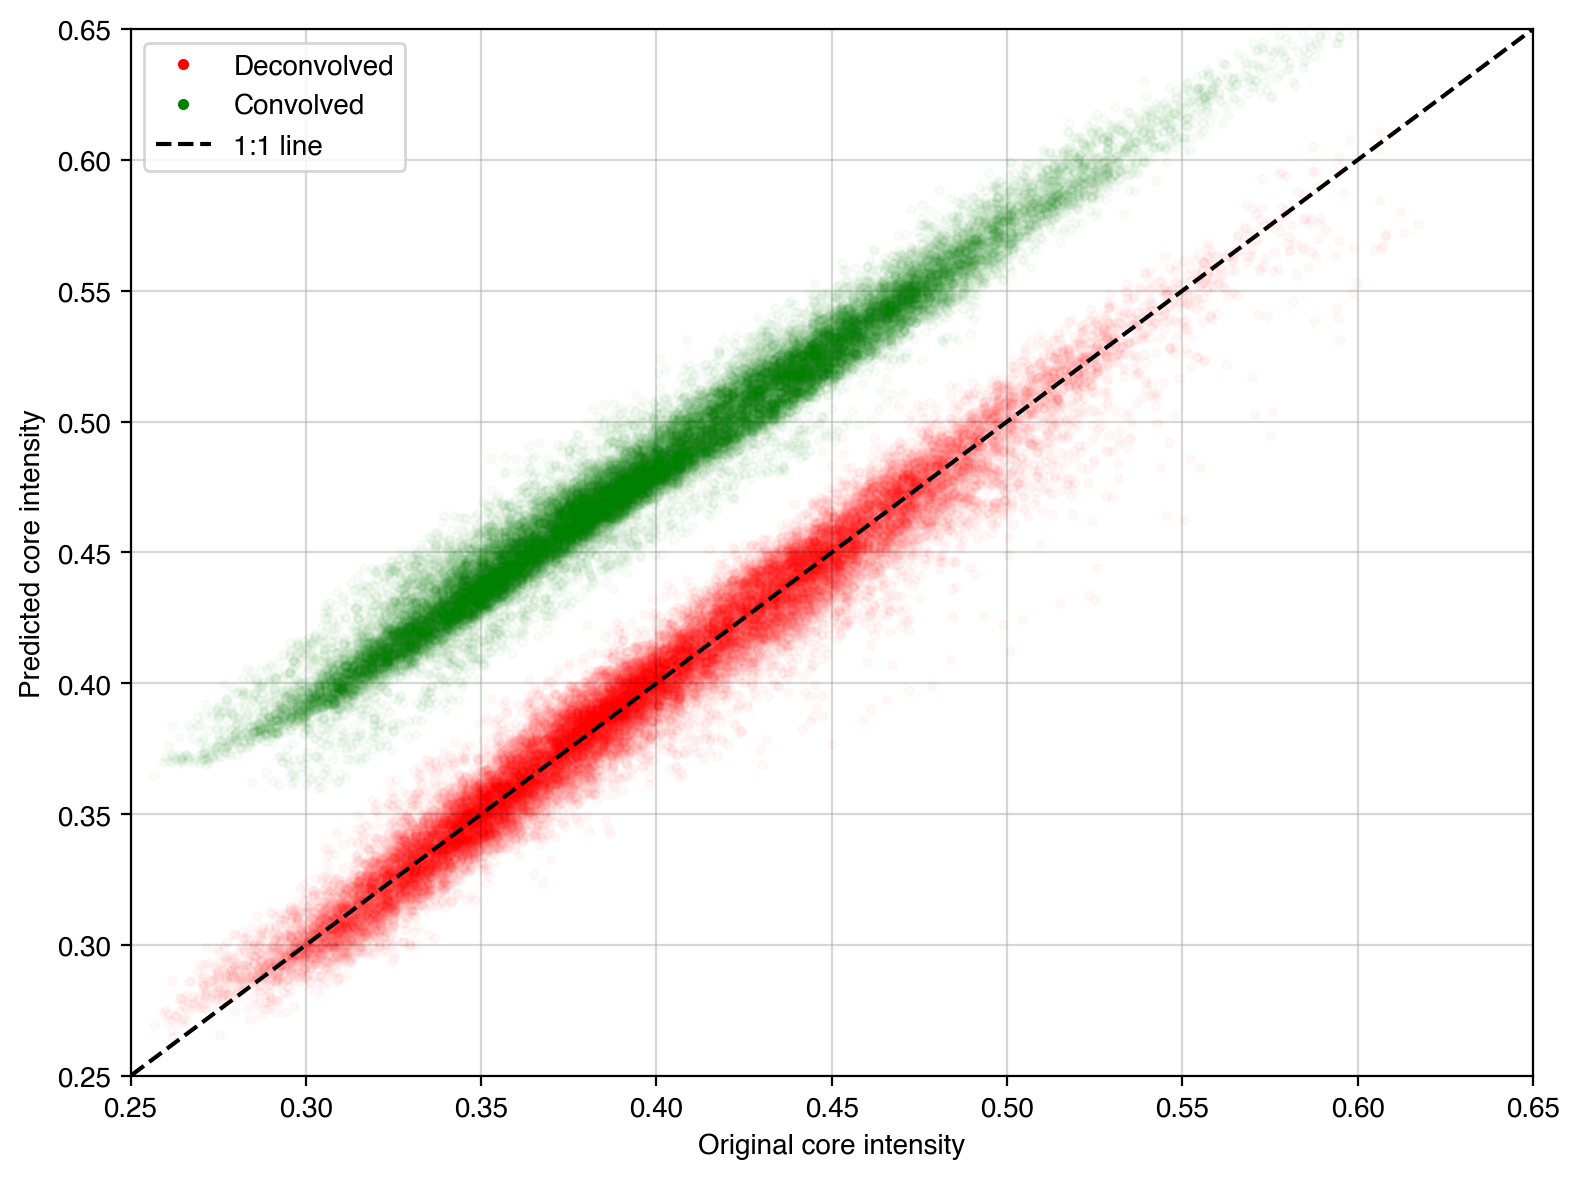

In [204]:
fSizeAxisLabel = 10

caData_test = load_spectral_profiles('', 'FISS_20160622_174907_B1.fts')

caConvolved_test = np.zeros((Nx_ca,Ny_ca, 502))
 
TProfile = produce_FP_transmission_peak(caSpectralRes, 0, Nlambda_ca, 2, 6563)

TProfile[0:140] = 0
TProfile[360:] = 0
TProfile = TProfile / np.sum(TProfile)
ax[0, 0].plot(TProfile)
    

for ii in range(Nx_ca):
    for jj in range(Ny_ca):
        caConvolved_test[ii, jj, :] = np.convolve(caData_test[ii, jj, :], TProfile, mode='same')
        
caConvolved_test = np.reshape(caConvolved_test, (Nx_ca*Ny_ca, 502, 1))
caData_test      = np.reshape(caData_test, (Nx_ca*Ny_ca, 502))

caData_test1      = caData_test[:, lStart:lEnd]
caConvolved_test1 = caConvolved_test[:, lStart:lEnd, :]

#plt.plot(caData_test1[200,:]/norm_conv)
#plt.plot(caConvolved_test[200,:,0]/norm_conv)
#plt.show()
print(norm_conv)
evaluation = model1.evaluate(np.reshape(caData_Conv_norm, (int(Nx_ca*Ny_ca), dl, 1)),
                            np.reshape(caData_norm, (int(Nx_ca*Ny_ca), dl)))

evaluation = model1.evaluate(caConvolved_test1/norm_conv, caData_test1/norm_data, verbose=1)

start = time.process_time()

predict    = model1.predict(caConvolved_test1/norm_conv,verbose=1)
print("The elapsed time for 1M Pixel inversion is: %6.2f seconds"%(time.process_time() - start))
print(predict.shape)
m.rcParams.update({'font.sans-serif':'Helvetica'})
csfont = {'fontname':'Helvetica'}

wavex = np.linspace(np.amin(predict)-.05,np.amax(predict),num=1000)


plt.figure(dpi=200,figsize=(8,6))
plt.xlim(0.25, 0.65)
plt.ylim(0.25, 0.65)

plt.plot(np.amin(caData_test1/norm_conv,axis=1), np.amin(predict,axis=1), 'r.'
         ,alpha=0.022)
plt.plot(0,0,'r.',label='Deconvolved')
plt.plot(np.amin(caData_test1/norm_conv,axis=1),np.amin(caConvolved_test1/norm_conv,axis=1)
         ,'g.',alpha=0.022)
plt.plot(0,0,'g.',label='Convolved')
plt.plot(wavex,wavex,'k--',label='1:1 line')

np.savez('Fig2_3.npz', caData_test1, norm_conv, predict, caConvolved_test1, wavex)

plt.xlabel('Original core intensity', **csfont, fontsize = fSizeAxisLabel)
plt.ylabel('Predicted core intensity', **csfont, fontsize = fSizeAxisLabel)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('Figures/Linecore_int_int.png',transparent=True)
plt.show()

237 277
235 280
(25000, 0)


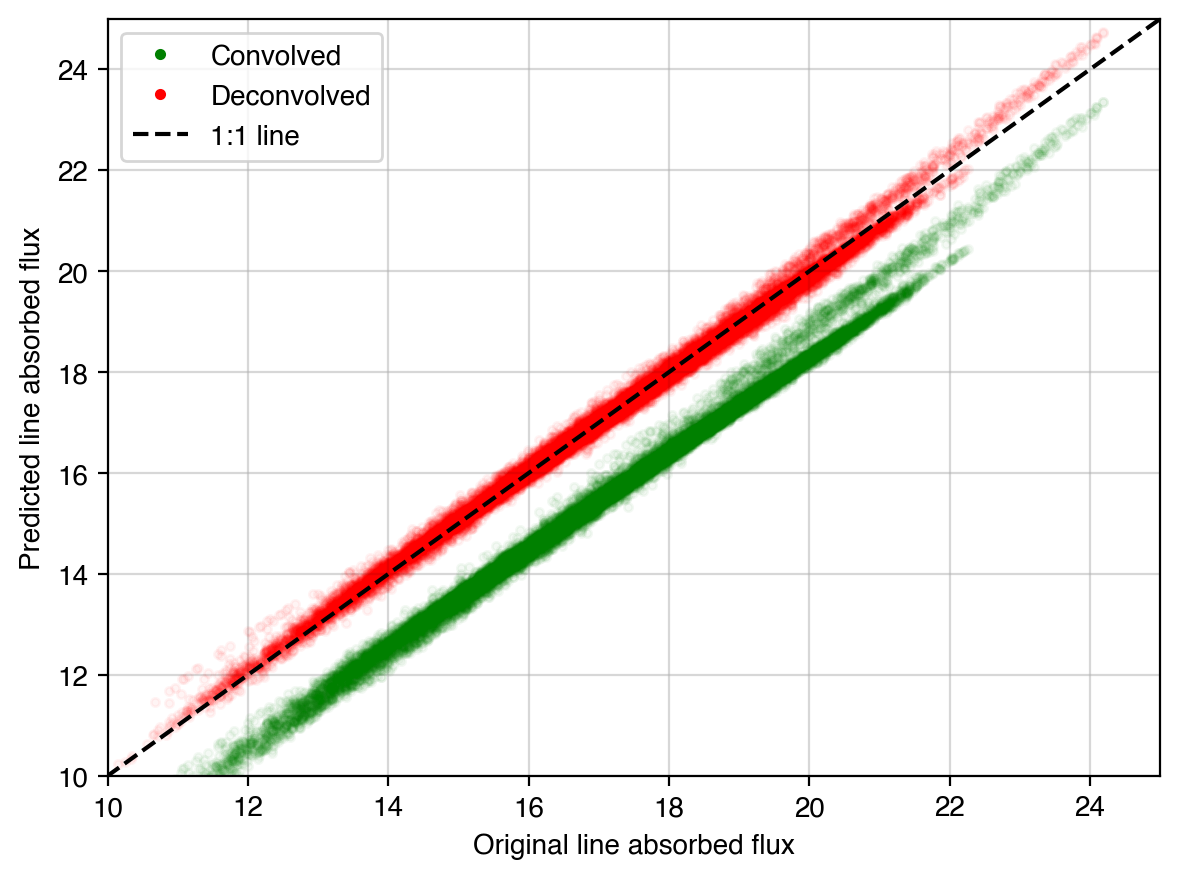

In [205]:
print(lStart1,lEnd1)
print(lStart,lEnd)
print(caData_test1[:,lStart1:lEnd1].shape)

x_min = 10
x_max = 25

m.rcParams.update({'font.sans-serif':'Helvetica'})
csfont = {'fontname':'Helvetica'}
wavex = np.linspace(0,200,num=1000)
plt.figure(dpi=200,figsize=(6,4.5))
plt.xlim(x_min,x_max)
plt.ylim(x_min,x_max)

plt.plot(45-np.sum(caData_test1/norm_conv,axis=1), 45-np.sum(predict,axis=1),
         'r.', alpha=0.042)

plt.plot(45 - np.sum(caData_test1/norm_conv,axis=1),
         45 - np.sum(caConvolved_test1/norm_conv,axis=1), 'g.', alpha=0.042)

plt.plot(0, 0, 'g.', label='Convolved')
plt.plot(0, 0, 'r.', label='Deconvolved')

plt.plot(wavex, wavex, 'k--', label='1:1 line')


plt.xlabel('Original line absorbed flux',**csfont,fontsize = fSizeAxisLabel)
plt.ylabel('Predicted line absorbed flux',**csfont,fontsize = fSizeAxisLabel)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('Figures/Linecore_flux_flux.png',transparent=True)
plt.show()

In [549]:
caDataHDU = fits.PrimaryHDU(caData_test1/norm_conv)
caDataHDU.writeto('caData_original.fits')

caDataConvHDU = fits.PrimaryHDU(caConvolved_test1/norm_conv)
caDataConvHDU.writeto('caData_Conv.fits')
 
resHDU   = fits.PrimaryHDU(predict)
resHDU.writeto('caData_res.fits')

## Convolve with a multi-peak PSF and try to reproduce the line profile

dl is 300
Number of measurements: 60.0


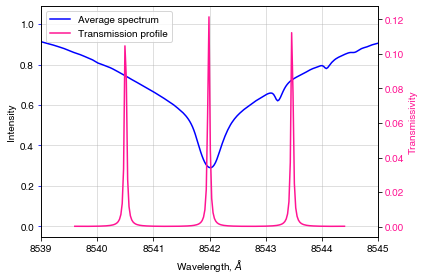

(25000, 60, 1)


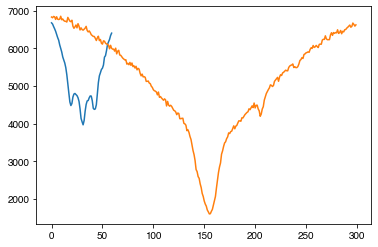

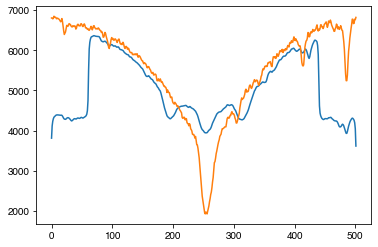

In [11]:
Nlambda      = 200
dlambda      = 0.024
color2 = 'deeppink'
redux_ratio  = 5
norm_conv = 5000

color1 = 'blue'
trans_filter = produce_FP_transmission_peak(caSpectralRes,0,Nlambda,1,8542)
trans_filter = trans_filter / np.sum(trans_filter)
wave         = np.linspace(-.5*Nlambda*dlambda,.5*Nlambda*dlambda,num=Nlambda)+8542.
wave502      = np.linspace(502*dlambda/(-2),502*dlambda/2,num=502)+8541.9


lStart1 = 100 
lEnd1   = 400
dl1 = lEnd1 - lStart1
print(f'dl is {dl1}')
print(f'Number of measurements: {dl1/redux_ratio}')

fig1, ax1 = plt.subplots()

fig1.set_dpi=400
fig1.set_size_inches(6,4)
ax1.plot(wave502,np.mean(caData,axis=(0,1))/7000,label='Average spectrum',color=color1)
ax1.tick_params(axis='y', color=color1)
ax1.set_xlabel('Wavelength, $\\AA$')
ax1.set_ylabel('Intensity')
ax1.set_xlim(8542-3, 8542+3)
ax1.plot(0, 0, '-', color=color2, label='Transmission profile')
ax1.grid(alpha=0.5)

ax2 = ax1.twinx() 

ax2.set_ylabel('Transmissivity', color=color2)
ax2.plot(wave, trans_filter, color=color2, label='Transmission profile')
ax2.tick_params(axis='y', labelcolor=color2)
ax1.legend(loc=2)
fig1.tight_layout()
fig1.savefig('Figures/Multiplex_2.png', transparent=True)
plt.show()
plt.close()


caConvolvedMP = np.zeros((Nx_ca*Ny_ca, int(dl1/redux_ratio), 1))

caData1       = np.reshape(caData, (Nx_ca*Ny_ca, 502))

for ii in range(Nx_ca*Ny_ca):
    caConvolvedMP[ii, :, 0] = (np.convolve(caData1[ii, :], trans_filter, 
                                         mode='same'))[(lStart1):(lEnd1):(redux_ratio)]

print(caConvolvedMP.shape)
plt.plot(caConvolvedMP[2301, :])
plt.plot(caData1[2301, lStart1:lEnd1])
plt.show()

plt.plot(np.convolve(caData1[ii, :], trans_filter, mode='same'))
plt.plot(caData1[ii, :])
plt.show()

In [10]:
modelMP = build_conv_model_MP(dl1, redux_ratio)
modelMP.summary()

NameError: name 'dl1' is not defined

In [285]:
EPOCHS = 10000
#print(train_set)

optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    modelMP.optimizer = tf.keras.optimizers.Adam(lr=3e-2, beta_1=0.9,
              beta_2=0.999, epsilon=1e-8, decay=1.0, amsgrad=False)
    
if optimizer == 'SGD': 
    modelMP.optimizer = tf.keras.optimizers.SGD(lr=1e-2, nesterov=True)

history = modelMP.fit((caConvolvedMP)/norm_conv,caData1[:,lStart1:lEnd1]/norm_conv,
                      epochs=EPOCHS,validation_split=0.15 , verbose=2)

Train on 21250 samples, validate on 3750 samples
Epoch 1/10000
21250/21250 - 4s - loss: 0.0134 - mean_absolute_error: 0.0572 - mean_squared_error: 0.0134 - val_loss: 0.0023 - val_mean_absolute_error: 0.0354 - val_mean_squared_error: 0.0023
Epoch 2/10000
21250/21250 - 3s - loss: 0.0039 - mean_absolute_error: 0.0411 - mean_squared_error: 0.0039 - val_loss: 0.0022 - val_mean_absolute_error: 0.0350 - val_mean_squared_error: 0.0022
Epoch 3/10000
21250/21250 - 3s - loss: 0.0039 - mean_absolute_error: 0.0409 - mean_squared_error: 0.0039 - val_loss: 0.0022 - val_mean_absolute_error: 0.0348 - val_mean_squared_error: 0.0022
Epoch 4/10000
21250/21250 - 3s - loss: 0.0039 - mean_absolute_error: 0.0408 - mean_squared_error: 0.0039 - val_loss: 0.0022 - val_mean_absolute_error: 0.0348 - val_mean_squared_error: 0.0022
Epoch 5/10000
21250/21250 - 3s - loss: 0.0039 - mean_absolute_error: 0.0407 - mean_squared_error: 0.0039 - val_loss: 0.0022 - val_mean_absolute_error: 0.0347 - val_mean_squared_error: 0.0

Epoch 44/10000
21250/21250 - 3s - loss: 0.0029 - mean_absolute_error: 0.0358 - mean_squared_error: 0.0029 - val_loss: 0.0018 - val_mean_absolute_error: 0.0309 - val_mean_squared_error: 0.0018
Epoch 45/10000
21250/21250 - 3s - loss: 0.0029 - mean_absolute_error: 0.0358 - mean_squared_error: 0.0029 - val_loss: 0.0018 - val_mean_absolute_error: 0.0309 - val_mean_squared_error: 0.0018
Epoch 46/10000
21250/21250 - 3s - loss: 0.0029 - mean_absolute_error: 0.0357 - mean_squared_error: 0.0029 - val_loss: 0.0018 - val_mean_absolute_error: 0.0309 - val_mean_squared_error: 0.0018
Epoch 47/10000
21250/21250 - 3s - loss: 0.0029 - mean_absolute_error: 0.0357 - mean_squared_error: 0.0029 - val_loss: 0.0018 - val_mean_absolute_error: 0.0309 - val_mean_squared_error: 0.0018
Epoch 48/10000
21250/21250 - 3s - loss: 0.0029 - mean_absolute_error: 0.0356 - mean_squared_error: 0.0029 - val_loss: 0.0018 - val_mean_absolute_error: 0.0309 - val_mean_squared_error: 0.0018
Epoch 49/10000
21250/21250 - 3s - loss: 

Epoch 87/10000
21250/21250 - 3s - loss: 0.0027 - mean_absolute_error: 0.0347 - mean_squared_error: 0.0027 - val_loss: 0.0017 - val_mean_absolute_error: 0.0301 - val_mean_squared_error: 0.0017
Epoch 88/10000
21250/21250 - 3s - loss: 0.0027 - mean_absolute_error: 0.0347 - mean_squared_error: 0.0027 - val_loss: 0.0017 - val_mean_absolute_error: 0.0301 - val_mean_squared_error: 0.0017
Epoch 89/10000
21250/21250 - 3s - loss: 0.0027 - mean_absolute_error: 0.0347 - mean_squared_error: 0.0027 - val_loss: 0.0017 - val_mean_absolute_error: 0.0301 - val_mean_squared_error: 0.0017
Epoch 90/10000
21250/21250 - 3s - loss: 0.0027 - mean_absolute_error: 0.0346 - mean_squared_error: 0.0027 - val_loss: 0.0017 - val_mean_absolute_error: 0.0300 - val_mean_squared_error: 0.0017
Epoch 91/10000
21250/21250 - 3s - loss: 0.0027 - mean_absolute_error: 0.0346 - mean_squared_error: 0.0027 - val_loss: 0.0017 - val_mean_absolute_error: 0.0300 - val_mean_squared_error: 0.0017
Epoch 92/10000
21250/21250 - 3s - loss: 

Epoch 130/10000
21250/21250 - 3s - loss: 0.0026 - mean_absolute_error: 0.0341 - mean_squared_error: 0.0026 - val_loss: 0.0016 - val_mean_absolute_error: 0.0296 - val_mean_squared_error: 0.0016
Epoch 131/10000
21250/21250 - 3s - loss: 0.0026 - mean_absolute_error: 0.0341 - mean_squared_error: 0.0026 - val_loss: 0.0016 - val_mean_absolute_error: 0.0296 - val_mean_squared_error: 0.0016
Epoch 132/10000
21250/21250 - 3s - loss: 0.0026 - mean_absolute_error: 0.0341 - mean_squared_error: 0.0026 - val_loss: 0.0016 - val_mean_absolute_error: 0.0296 - val_mean_squared_error: 0.0016
Epoch 133/10000
21250/21250 - 3s - loss: 0.0026 - mean_absolute_error: 0.0340 - mean_squared_error: 0.0026 - val_loss: 0.0016 - val_mean_absolute_error: 0.0296 - val_mean_squared_error: 0.0016
Epoch 134/10000
21250/21250 - 3s - loss: 0.0026 - mean_absolute_error: 0.0340 - mean_squared_error: 0.0026 - val_loss: 0.0016 - val_mean_absolute_error: 0.0296 - val_mean_squared_error: 0.0016
Epoch 135/10000
21250/21250 - 3s - 

Epoch 173/10000
21250/21250 - 3s - loss: 0.0025 - mean_absolute_error: 0.0337 - mean_squared_error: 0.0025 - val_loss: 0.0016 - val_mean_absolute_error: 0.0293 - val_mean_squared_error: 0.0016
Epoch 174/10000
21250/21250 - 3s - loss: 0.0025 - mean_absolute_error: 0.0337 - mean_squared_error: 0.0025 - val_loss: 0.0016 - val_mean_absolute_error: 0.0292 - val_mean_squared_error: 0.0016
Epoch 175/10000
21250/21250 - 3s - loss: 0.0025 - mean_absolute_error: 0.0336 - mean_squared_error: 0.0025 - val_loss: 0.0016 - val_mean_absolute_error: 0.0292 - val_mean_squared_error: 0.0016
Epoch 176/10000
21250/21250 - 3s - loss: 0.0025 - mean_absolute_error: 0.0336 - mean_squared_error: 0.0025 - val_loss: 0.0016 - val_mean_absolute_error: 0.0292 - val_mean_squared_error: 0.0016
Epoch 177/10000
21250/21250 - 3s - loss: 0.0025 - mean_absolute_error: 0.0336 - mean_squared_error: 0.0025 - val_loss: 0.0016 - val_mean_absolute_error: 0.0292 - val_mean_squared_error: 0.0016
Epoch 178/10000
21250/21250 - 3s - 

Epoch 216/10000
21250/21250 - 3s - loss: 0.0025 - mean_absolute_error: 0.0333 - mean_squared_error: 0.0025 - val_loss: 0.0016 - val_mean_absolute_error: 0.0290 - val_mean_squared_error: 0.0016
Epoch 217/10000
21250/21250 - 3s - loss: 0.0025 - mean_absolute_error: 0.0333 - mean_squared_error: 0.0025 - val_loss: 0.0016 - val_mean_absolute_error: 0.0290 - val_mean_squared_error: 0.0016
Epoch 218/10000
21250/21250 - 3s - loss: 0.0025 - mean_absolute_error: 0.0333 - mean_squared_error: 0.0025 - val_loss: 0.0016 - val_mean_absolute_error: 0.0290 - val_mean_squared_error: 0.0016
Epoch 219/10000
21250/21250 - 3s - loss: 0.0025 - mean_absolute_error: 0.0333 - mean_squared_error: 0.0025 - val_loss: 0.0016 - val_mean_absolute_error: 0.0290 - val_mean_squared_error: 0.0016
Epoch 220/10000
21250/21250 - 3s - loss: 0.0025 - mean_absolute_error: 0.0333 - mean_squared_error: 0.0025 - val_loss: 0.0016 - val_mean_absolute_error: 0.0290 - val_mean_squared_error: 0.0016
Epoch 221/10000
21250/21250 - 3s - 

Epoch 259/10000
21250/21250 - 3s - loss: 0.0024 - mean_absolute_error: 0.0330 - mean_squared_error: 0.0024 - val_loss: 0.0015 - val_mean_absolute_error: 0.0288 - val_mean_squared_error: 0.0015
Epoch 260/10000
21250/21250 - 3s - loss: 0.0024 - mean_absolute_error: 0.0330 - mean_squared_error: 0.0024 - val_loss: 0.0015 - val_mean_absolute_error: 0.0287 - val_mean_squared_error: 0.0015
Epoch 261/10000
21250/21250 - 3s - loss: 0.0024 - mean_absolute_error: 0.0330 - mean_squared_error: 0.0024 - val_loss: 0.0015 - val_mean_absolute_error: 0.0287 - val_mean_squared_error: 0.0015
Epoch 262/10000
21250/21250 - 3s - loss: 0.0024 - mean_absolute_error: 0.0330 - mean_squared_error: 0.0024 - val_loss: 0.0015 - val_mean_absolute_error: 0.0287 - val_mean_squared_error: 0.0015
Epoch 263/10000
21250/21250 - 3s - loss: 0.0024 - mean_absolute_error: 0.0330 - mean_squared_error: 0.0024 - val_loss: 0.0015 - val_mean_absolute_error: 0.0287 - val_mean_squared_error: 0.0015
Epoch 264/10000
21250/21250 - 3s - 

Epoch 302/10000
21250/21250 - 3s - loss: 0.0024 - mean_absolute_error: 0.0328 - mean_squared_error: 0.0024 - val_loss: 0.0015 - val_mean_absolute_error: 0.0286 - val_mean_squared_error: 0.0015
Epoch 303/10000
21250/21250 - 3s - loss: 0.0024 - mean_absolute_error: 0.0328 - mean_squared_error: 0.0024 - val_loss: 0.0015 - val_mean_absolute_error: 0.0286 - val_mean_squared_error: 0.0015
Epoch 304/10000
21250/21250 - 3s - loss: 0.0024 - mean_absolute_error: 0.0328 - mean_squared_error: 0.0024 - val_loss: 0.0015 - val_mean_absolute_error: 0.0285 - val_mean_squared_error: 0.0015
Epoch 305/10000
21250/21250 - 3s - loss: 0.0024 - mean_absolute_error: 0.0328 - mean_squared_error: 0.0024 - val_loss: 0.0015 - val_mean_absolute_error: 0.0285 - val_mean_squared_error: 0.0015
Epoch 306/10000
21250/21250 - 3s - loss: 0.0024 - mean_absolute_error: 0.0328 - mean_squared_error: 0.0024 - val_loss: 0.0015 - val_mean_absolute_error: 0.0285 - val_mean_squared_error: 0.0015
Epoch 307/10000
21250/21250 - 3s - 

Epoch 345/10000
21250/21250 - 3s - loss: 0.0023 - mean_absolute_error: 0.0326 - mean_squared_error: 0.0023 - val_loss: 0.0015 - val_mean_absolute_error: 0.0284 - val_mean_squared_error: 0.0015
Epoch 346/10000
21250/21250 - 4s - loss: 0.0023 - mean_absolute_error: 0.0326 - mean_squared_error: 0.0023 - val_loss: 0.0015 - val_mean_absolute_error: 0.0284 - val_mean_squared_error: 0.0015
Epoch 347/10000
21250/21250 - 4s - loss: 0.0023 - mean_absolute_error: 0.0326 - mean_squared_error: 0.0023 - val_loss: 0.0015 - val_mean_absolute_error: 0.0284 - val_mean_squared_error: 0.0015
Epoch 348/10000
21250/21250 - 3s - loss: 0.0023 - mean_absolute_error: 0.0326 - mean_squared_error: 0.0023 - val_loss: 0.0015 - val_mean_absolute_error: 0.0284 - val_mean_squared_error: 0.0015
Epoch 349/10000
21250/21250 - 3s - loss: 0.0023 - mean_absolute_error: 0.0326 - mean_squared_error: 0.0023 - val_loss: 0.0015 - val_mean_absolute_error: 0.0284 - val_mean_squared_error: 0.0015
Epoch 350/10000
21250/21250 - 3s - 

KeyboardInterrupt: 

(100, 250, 40)
(25000, 60, 1)


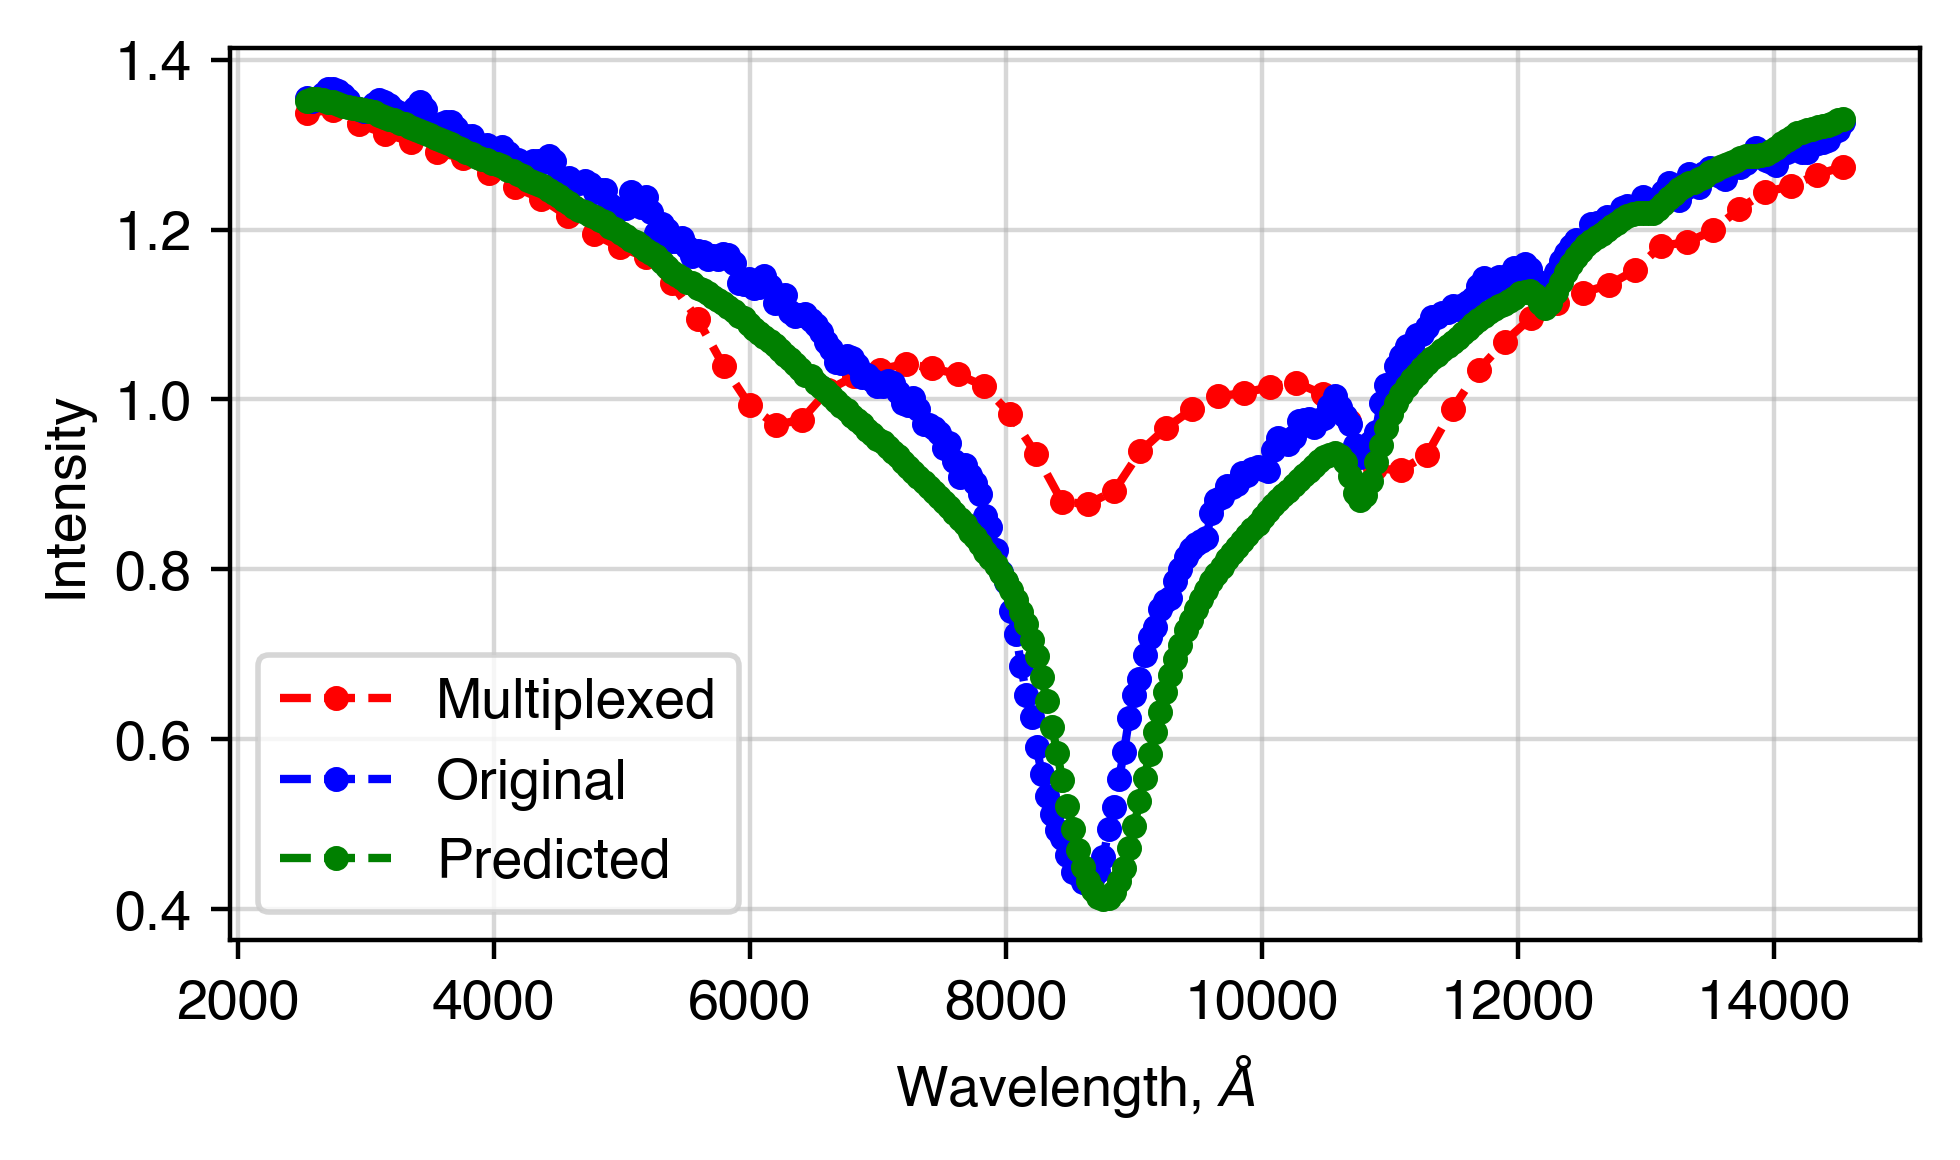

In [288]:
prevNum  = 12010
delta    = 1

dlambda1     = 0.025
markersizex  = 7
print(caData_Conv_norm.shape)
res = modelMP.predict(caConvolvedMP[prevNum:prevNum+delta]/5000)

wavescale  = np.linspace(-10*dl1*2+8542.0,10*dl1*2+8542.0,num=dl1)
print(caConvolvedMP.shape)
wavescale1 = np.linspace(-10*dl1*2+8542.0,10*dl1*2+8542.0,num=dl1/redux_ratio)
#plot_spec_profile_comparison(wavescale,caConvolvedMP[prevNum:prevNum,:]/5000,
                            #caData1[prevNum:prevNum,::2]/5000,res[0,0:-1:2])
plt.figure(dpi=400,figsize=(5,3))

plt.plot(wavescale1,(caConvolvedMP[prevNum,:,0])/5000,'r--.',label='Multiplexed',markersize = markersizex)
plt.plot(wavescale,caData1[prevNum,lStart1:lEnd1]/5000,'b--.',label='Original',markersize = markersizex)
plt.plot(wavescale,res[0,:],'g--.',label='Predicted',markersize = markersizex)
plt.grid(alpha=0.5)
plt.xlabel('Wavelength, $\\AA$')
plt.ylabel('Intensity')
plt.legend()
plt.tight_layout()
plt.savefig('Figures/MP_fail.png',transparent = True)
plt.show()

[0.286  0.291  0.2912 ... 0.3758 0.3856 0.3852]
[0.4053861  0.40589952 0.40693015 ... 0.40180945 0.40143615 0.40105683]


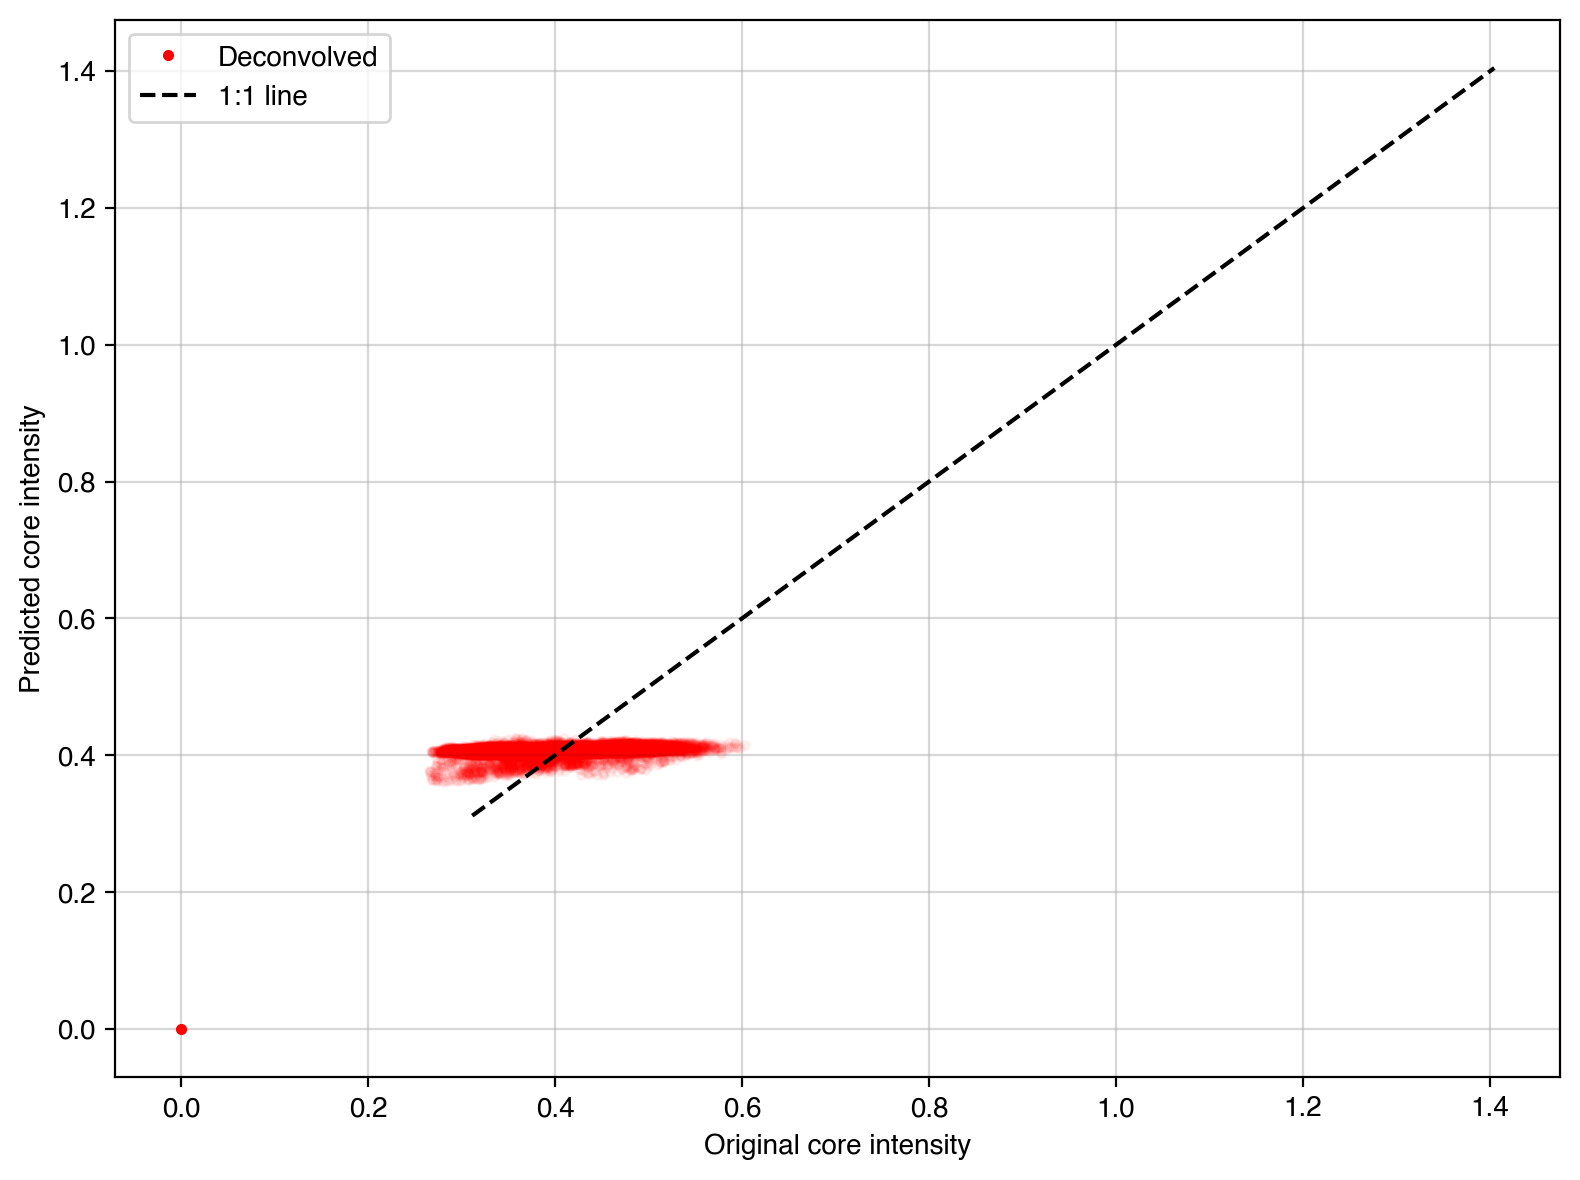

In [287]:
predict = modelMP.predict(caConvolvedMP/norm_conv)

wavex = np.linspace(np.amin(predict)-.05,np.amax(predict),num=1000)

norm_conv = 5000
plt.figure(dpi=200,figsize=(8,6))

print(np.amin(caData1[:, lStart1:lEnd1]/norm_conv, axis=1))
print(np.amin(predict,axis=1))

plt.plot(np.amin(caData1[:, lStart1:lEnd1]/norm_conv, axis=1),
         np.amin(predict,axis=1), 'r.' ,alpha=0.042)
plt.plot(0,0,'r.',label='Deconvolved')

plt.plot(wavex,wavex,'k--',label='1:1 line')

plt.xlabel('Original core intensity')
plt.ylabel('Predicted core intensity')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

### Estimate the amount of information in the multiplexed data

In [10]:
print(len(caData1[::10,lStart1:lEnd1]))
N_spectra = 2500
print(N_spectra, dl1)
data_array = np.zeros((N_spectra, dl1))
for ii in range(N_spectra):
    data_array[ii, :] = caData1[ii*10,lStart1:lEnd1]/5000
k1 = 2 # start of interval(included)
k2 = 10 # end of interval(included)
intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             data_array/norm_conv, nb_iter=5,
                             mode='same', 
                             #nb_iter=3, # nb_iter for bootstrapping
                             verbose=0, 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)


  0%|          | 0/5 [00:00<?, ?it/s]

2500
2500 300


/Users/molnarad/CU_Boulder/Work/Chromospheric_business/CNNs/SPSF_remove/intdim_mle.py:42: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)


KeyboardInterrupt: 

In [14]:
num_k  = 10
k0     = 3
k1     = 400


k_values = np.logspace(np.log10(k0), np.log10(k1), num=num_k)
intdim_k = [] 

N_spectra = 10000
print(caConvolvedMP.shape)
data_array = np.zeros((N_spectra, 60))
for ii in range(N_spectra):
    data_array[ii, :] = caConvolvedMP[ii*2,:, 0]/5000

for k in k_values:
    intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                                 data_array/norm_conv, 
                                 mode='same', nb_iter=1,
                                 #nb_iter=3, # nb_iter for bootstrapping
                                 verbose=1, 
                                 k1=int(k), k2=int(k))
    intdim_k.append([int(k), intdim_k_repeated])
    print(f'{k} calculated')



  0%|          | 0/1 [00:00<?, ?it/s]

(25000, 60, 1)



100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[[7.52462367e-06 9.51813443e-06 9.72652816e-06]
 [9.19443159e-06 9.63646118e-06 1.05973279e-05]
 [9.04814324e-06 9.24309265e-06 9.34007777e-06]
 ...
 [5.48134574e-06 5.69565917e-06 6.38932463e-06]
 [6.29808519e-06 6.51136838e-06 6.76594312e-06]
 [5.68565149e-06 6.69251019e-06 6.80962244e-06]]
3.0 calculated



100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[[7.52462367e-06 9.51813443e-06 9.72652816e-06 1.01132660e-05
  1.01792070e-05]
 [9.19443159e-06 9.63646118e-06 1.05973279e-05 1.07014807e-05
  1.15273453e-05]
 [9.04814324e-06 9.24309265e-06 9.34007777e-06 1.02050920e-05
  1.13391760e-05]
 ...
 [5.48134574e-06 5.69565917e-06 6.38932463e-06 6.82159341e-06
  6.90777324e-06]
 [6.29808519e-06 6.51136838e-06 6.76594312e-06 6.80962244e-06
  6.92082403e-06]
 [5.68565149e-06 6.69251019e-06 6.80962244e-06 6.97051452e-06
  7.03280947e-06]]
5.166846492264712 calculated



100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[[7.52462367e-06 9.51813443e-06 9.72652816e-06 ... 1.07245591e-05
  1.16171908e-05 1.16676853e-05]
 [9.19443159e-06 9.63646118e-06 1.05973279e-05 ... 1.19562895e-05
  1.20591964e-05 1.24636428e-05]
 [9.04814324e-06 9.24309265e-06 9.34007777e-06 ... 1.20522422e-05
  1.23221411e-05 1.23339713e-05]
 ...
 [5.48134574e-06 5.69565917e-06 6.38932463e-06 ... 7.57586680e-06
  7.67921299e-06 8.08654591e-06]
 [6.29808519e-06 6.51136838e-06 6.76594312e-06 ... 6.97336414e-06
  7.18498019e-06 7.22895192e-06]
 [5.68565149e-06 6.69251019e-06 6.80962244e-06 ... 7.10377734e-06
  7.15163357e-06 7.71714815e-06]]
8.898767558209384 calculated



100%|██████████| 1/1 [00:02<00:00,  2.35s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[[7.52462367e-06 9.51813443e-06 9.72652816e-06 ... 1.21476093e-05
  1.21740483e-05 1.23228908e-05]
 [9.19443159e-06 9.63646118e-06 1.05973279e-05 ... 1.27665403e-05
  1.29549398e-05 1.31130671e-05]
 [9.04814324e-06 9.24309265e-06 9.34007777e-06 ... 1.42619395e-05
  1.42840501e-05 1.43606974e-05]
 ...
 [5.48134574e-06 5.69565917e-06 6.38932463e-06 ... 8.70313124e-06
  8.73543362e-06 8.75320421e-06]
 [6.29808519e-06 6.51136838e-06 6.76594312e-06 ... 7.86148495e-06
  7.91474317e-06 7.93837843e-06]
 [5.68565149e-06 6.69251019e-06 6.80962244e-06 ... 7.86133949e-06
  8.09526417e-06 8.13800307e-06]]
15.326188647871062 calculated



100%|██████████| 1/1 [00:02<00:00,  2.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[[7.52462367e-06 9.51813443e-06 9.72652816e-06 ... 1.30397475e-05
  1.30675116e-05 1.31133662e-05]
 [9.19443159e-06 9.63646118e-06 1.05973279e-05 ... 1.41747044e-05
  1.42558868e-05 1.43172462e-05]
 [9.04814324e-06 9.24309265e-06 9.34007777e-06 ... 1.50387393e-05
  1.50449144e-05 1.51971050e-05]
 ...
 [5.48134574e-06 5.69565917e-06 6.38932463e-06 ... 9.22690909e-06
  9.38216374e-06 9.42358765e-06]
 [6.29808519e-06 6.51136838e-06 6.76594312e-06 ... 8.59327334e-06
  8.59925545e-06 8.81582397e-06]
 [5.68565149e-06 6.69251019e-06 6.80962244e-06 ... 8.89715153e-06
  8.94780724e-06 9.02961504e-06]]
26.39602135167994 calculated



100%|██████████| 1/1 [00:02<00:00,  2.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[[7.52462367e-06 9.51813443e-06 9.72652816e-06 ... 1.39239486e-05
  1.39471548e-05 1.39718644e-05]
 [9.19443159e-06 9.63646118e-06 1.05973279e-05 ... 1.56128963e-05
  1.56226328e-05 1.57343047e-05]
 [9.04814324e-06 9.24309265e-06 9.34007777e-06 ... 1.62712281e-05
  1.62775700e-05 1.63536734e-05]
 ...
 [5.48134574e-06 5.69565917e-06 6.38932463e-06 ... 1.01299616e-05
  1.02895336e-05 1.03050390e-05]
 [6.29808519e-06 6.51136838e-06 6.76594312e-06 ... 9.77566121e-06
  9.82379058e-06 9.92542285e-06]
 [5.68565149e-06 6.69251019e-06 6.80962244e-06 ... 9.64657295e-06
  9.71476043e-06 9.72173892e-06]]
45.46139677689066 calculated



100%|██████████| 1/1 [00:03<00:00,  3.34s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[[7.52462367e-06 9.51813443e-06 9.72652816e-06 ... 1.51277176e-05
  1.51451028e-05 1.51921708e-05]
 [9.19443159e-06 9.63646118e-06 1.05973279e-05 ... 1.68840558e-05
  1.69396233e-05 1.69637016e-05]
 [9.04814324e-06 9.24309265e-06 9.34007777e-06 ... 1.82015664e-05
  1.83287040e-05 1.83459787e-05]
 ...
 [5.48134574e-06 5.69565917e-06 6.38932463e-06 ... 1.11761636e-05
  1.12015226e-05 1.12222253e-05]
 [6.29808519e-06 6.51136838e-06 6.76594312e-06 ... 1.11799958e-05
  1.11804051e-05 1.11808422e-05]
 [5.68565149e-06 6.69251019e-06 6.80962244e-06 ... 1.11143872e-05
  1.11590761e-05 1.11699238e-05]]
78.29735282337724 calculated



100%|██████████| 1/1 [00:03<00:00,  3.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[[7.52462367e-06 9.51813443e-06 9.72652816e-06 ... 1.66837289e-05
  1.67201037e-05 1.67573096e-05]
 [9.19443159e-06 9.63646118e-06 1.05973279e-05 ... 1.82453055e-05
  1.82929774e-05 1.83175693e-05]
 [9.04814324e-06 9.24309265e-06 9.34007777e-06 ... 2.05792804e-05
  2.05797207e-05 2.06127074e-05]
 ...
 [5.48134574e-06 5.69565917e-06 6.38932463e-06 ... 1.25464528e-05
  1.25522104e-05 1.25624331e-05]
 [6.29808519e-06 6.51136838e-06 6.76594312e-06 ... 1.28203754e-05
  1.28234573e-05 1.28260179e-05]
 [5.68565149e-06 6.69251019e-06 6.80962244e-06 ... 1.26017593e-05
  1.26043249e-05 1.26127188e-05]]
134.85013426302646 calculated



100%|██████████| 1/1 [00:04<00:00,  4.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[[7.52462367e-06 9.51813443e-06 9.72652816e-06 ... 1.84234568e-05
  1.84276281e-05 1.84307914e-05]
 [9.19443159e-06 9.63646118e-06 1.05973279e-05 ... 2.01844359e-05
  2.02023119e-05 2.02157984e-05]
 [9.04814324e-06 9.24309265e-06 9.34007777e-06 ... 2.30912157e-05
  2.30923110e-05 2.30966646e-05]
 ...
 [5.48134574e-06 5.69565917e-06 6.38932463e-06 ... 1.41591273e-05
  1.41712734e-05 1.41764288e-05]
 [6.29808519e-06 6.51136838e-06 6.76594312e-06 ... 1.47283822e-05
  1.47492132e-05 1.47595737e-05]
 [5.68565149e-06 6.69251019e-06 6.80962244e-06 ... 1.41509734e-05
  1.41628601e-05 1.41635006e-05]]
232.2499810661146 calculated



100%|██████████| 1/1 [00:05<00:00,  5.80s/it]

[[7.52462367e-06 9.51813443e-06 9.72652816e-06 ... 2.02506815e-05
  2.02616625e-05 2.02640342e-05]
 [9.19443159e-06 9.63646118e-06 1.05973279e-05 ... 2.21506604e-05
  2.21511483e-05 2.21593684e-05]
 [9.04814324e-06 9.24309265e-06 9.34007777e-06 ... 2.64738457e-05
  2.64982340e-05 2.65063344e-05]
 ...
 [5.48134574e-06 5.69565917e-06 6.38932463e-06 ... 1.62826964e-05
  1.63126543e-05 1.63237087e-05]
 [6.29808519e-06 6.51136838e-06 6.76594312e-06 ... 1.66999719e-05
  1.67144807e-05 1.67217466e-05]
 [5.68565149e-06 6.69251019e-06 6.80962244e-06 ... 1.59822456e-05
  1.59949961e-05 1.59959447e-05]]
400.0000000000001 calculated


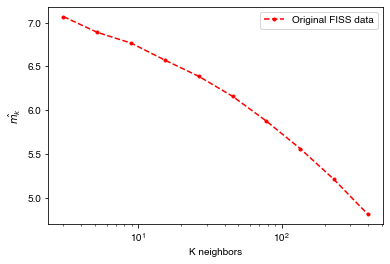

In [15]:
mean_m = np.zeros(num_k)
for jj in range(num_k):
    mean_m[jj] = np.mean(intdim_k[jj][1])

plt.plot(k_values, mean_m,'r.--', label='Original FISS data')
plt.xlabel('K neighbors')
plt.ylabel('$\hat{m_k}$')
plt.xscale('log')
plt.legend()
plt.show()

In [22]:
num_k  = 10
k0     = 3
k1     = 400


k_values = np.logspace(np.log10(k0), np.log10(k1), num=num_k)
intdim_k = []

N_spectra = 4900
print(N_spectra, dl1)
data_array = np.zeros((N_spectra, dl1))
for ii in range(N_spectra):
    data_array[ii, :] = caData1[ii*5,lStart1:lEnd1]/5000

for k in k_values:
    intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                                 data_array/norm_conv, 
                                 mode='shuffle', nb_iter=1, 
                                 #nb_iter=3, # nb_iter for bootstrapping
                                 verbose=0, 
                                 k1=int(k), k2=int(k))
    intdim_k.append([int(k), intdim_k_repeated])
    print(f'k={k:.3f} calculated')


4900 300
k=3.000 calculated
k=5.167 calculated
k=8.899 calculated
k=15.326 calculated
k=26.396 calculated
k=45.461 calculated
k=78.297 calculated
k=134.850 calculated
k=232.250 calculated
k=400.000 calculated


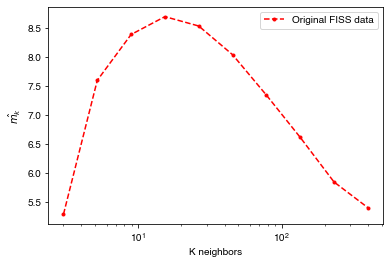

In [23]:
mean_m = np.zeros(num_k)


for jj in range(num_k):
    mean_m[jj] = np.mean(intdim_k[jj][1])

plt.plot(k_values, mean_m,'r.--', label='Original FISS data')
plt.xlabel('K neighbors')
plt.ylabel('$\hat{m_k}$')
plt.xscale('log')
plt.legend()
plt.show()

#### Test case for MLEID metric if it detects one free parameter

Introduce a sub-pixel shift of the same profile and compute the MLEID metric following Asensio Ramos et al., 2007

5.00 calculated
5.50 calculated
6.04 calculated
6.64 calculated
7.30 calculated
8.02 calculated
8.82 calculated
9.69 calculated
10.66 calculated
11.71 calculated
12.88 calculated
14.15 calculated
15.56 calculated
17.10 calculated
18.80 calculated
20.66 calculated
22.71 calculated
24.96 calculated
27.44 calculated
30.16 calculated
33.15 calculated
36.44 calculated
40.06 calculated
44.03 calculated
48.40 calculated
53.20 calculated
58.48 calculated
64.28 calculated
70.66 calculated
77.67 calculated
85.37 calculated
93.84 calculated
103.15 calculated
113.39 calculated
124.63 calculated
137.00 calculated
150.59 calculated
165.53 calculated
181.95 calculated
200.00 calculated


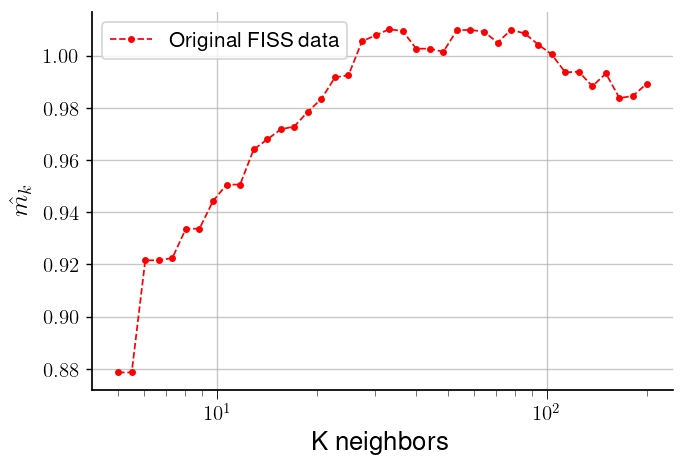

In [23]:
sample_profile = caData[50, 50, 200:330]
sample_profiles = np.array([(shift(sample_profile, np.random.rand()*10))[20:-20] for i in range(500)])

num_k  = 40
k0     = 5
k1     = 200


k_values = np.logspace(np.log10(k0), np.log10(k1), num=num_k)
intdim_k = []


for k in k_values:
    intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                                 sample_profiles, 
                                 mode='shuffle', nb_iter=2, 
                                 #nb_iter=3, # nb_iter for bootstrapping
                                 verbose=0, 
                                 k1=int(k), k2=int(k))
    intdim_k.append([int(k), intdim_k_repeated])
    print(f'{k:.2f} calculated')
    
mean_m = np.zeros(num_k)
for jj in range(num_k):
    mean_m[jj] = np.mean(intdim_k[jj][1])

plt.plot(k_values, mean_m,'r.--', label='Original FISS data')
plt.xlabel('K neighbors')
plt.ylabel('$\hat{m_k}$')
plt.xscale('log')
plt.grid(alpha=0.7)
plt.legend()
plt.show()

In [21]:
print(np.array(intdim_k[0][1]))

[[0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91161356]
 [0.91

In [ ]:
# TProfile -- transmission profile
# caConvolved[80, 20, lStart:lEnd]
# caData[80, 20, lStart:lEnd]

minTP = np.amin(TProfile)
TProfile_min = TProfile[240:-240]
print(f"TProfile dimensions are {TProfile_min.shape}")
for ii in range(len(TProfile_min)):
    if TProfile_min[ii] == 0:
        TProfile_min[ii] = 1e-3

plt.plot(TProfile_min)
plt.show()
        
print(f'shape of caData is {caData.shape}')
print(f'shape of caConvolved is {caConvolved.shape}')
plt.plot(caData[80, 20, lStart:lEnd], 'r.--', label='Original Data')
plt.plot(caConvolved[80, 20, lStart:lEnd], 'b.--', label='Convolved')

N_trials = 25000
start = time.process_time()
for ii in range(250):
    for jj in range(100):
        recovered, remainder = deconvolve(caConvolved[jj, ii, :], TProfile_min)
print(f"The elapsed time for {N_trials} inversion is {time.process_time() - start}")

plt.plot(recovered[lStart:lEnd], 'g.--', label='Recovered')
plt.ylim(np.amin(caConvolved[jj, ii, lStart:lEnd])*.5, np.amax(caConvolved[jj, ii, lStart:lEnd])*2)
plt.legend()
plt.show()


In [1]:
cont_index = 1
core_index = 256

fig, ax = plt.subplots(2,1)
fig.set_dpi(200)
fig.set_size_inches(6,4)
ax[0].imshow(caData[:,:,cont_index],cmap='hot',
             vmax=np.amax(caData[:,:,cont_index]),vmin=np.amin(caData[:,:,cont_index])*1.3)
ax[0].set_title('Continuum image')
ax[0].set_xticklabels([])
ax[0].set_ylabel('Solar Y, [pixels]')

ax[1].imshow(caData[:,:,core_index],cmap='gray',
             vmax=np.amax(caData[:,:,core_index]),vmin=np.amin(caData[:,:,core_index])*1.)
ax[1].set_title('8542 $\\AA$ line core Intensity')
ax[1].set_xlabel('Solar X, [pixels]')
ax[1].set_ylabel('Solar Y, [pixels]')

plt.tight_layout()

plt.savefig('Figures/FISS_FOV.png',transparent=True)
plt.show()

NameError: name 'plt' is not defined

The elapsed time for 250 inversion is 1.9011200000004465


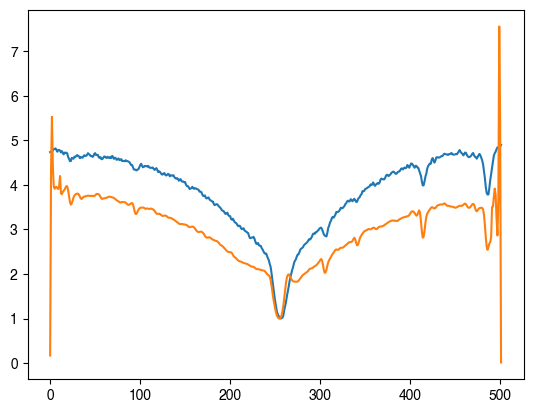

In [185]:
from skimage import color, data, restoration
TProfile_multiD = np.zeros((10, 25, 22))
for ii in range(10):
    for jj in range(25):
        TProfile_multiD[ii, jj, :] = TProfile_min[:]
start = time.process_time()
DL = restoration.richardson_lucy(caData[0:10, 0:25, :], TProfile_multiD, iterations=30)
print(f"The elapsed time for 250 inversion is {time.process_time() - start}")

plt.plot(caData[8,8,:]/np.amin(caData[8,8,100:300]))
plt.plot(DL[8,8,:]/np.amin(DL[8,8,100:300]))
plt.show()